# Customer Segmentation Analysis

## Overview

**Olist** is a digital  platform for seller and buyer to conduct a commercial transaction based in Brazil. The company was founded with the mission of helping small merchants gain market share across the country through a SaaS licensing model to small brick and mortar businesses.


### Problem Statement and Objective of Analysis

***Problem Statement:***

Significant decrease of Revenue in December 2017 after reach its peak in November 2017

***Objective of Analysis:***

Provide for each customer segmentation with 5Ps Marketing Strategies



### Scope of Analysis

The dataset has information of **100k orders** from **2016 to 2018** made at multiple marketplaces in Brazil.


In [ ]:
#Import necessarry library and packages

import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('stopwords')
%matplotlib inline
from nltk.corpus import stopwords
from wordcloud import WordCloud
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Custom view option

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
# Mounting from Google Drive

from google.colab import drive
drive.mount('/content/drive')

# Import datasets
prefix_path = '/content/drive/MyDrive/04. Dataset/Ollist_dataset/'

df_cus = pd.read_csv(prefix_path+'olist_customers_dataset.csv')
df_loc = pd.read_csv(prefix_path+'olist_geolocation_dataset.csv')
df_ord = pd.read_csv(prefix_path+'olist_order_items_dataset.csv')
df_pay = pd.read_csv(prefix_path+'olist_order_payments_dataset.csv')
df_rv  = pd.read_csv(prefix_path+'olist_order_reviews_dataset.csv')
df_ord_stt = pd.read_csv(prefix_path+'olist_orders_dataset.csv')
df_sel = pd.read_csv(prefix_path+'olist_sellers_dataset.csv')
df_prd_brz = pd.read_csv(prefix_path+'olist_products_dataset.csv')
df_prd_eng = pd.read_csv(prefix_path+'product_category_name_translation.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Consolidated datasets into one

df_prd = df_prd_brz.merge(df_prd_eng, how='inner', on='product_category_name').drop(columns='product_category_name')
df_merge_order = df_ord.merge(df_ord_stt, how='inner', on='order_id')
df_merge_ordprd = df_merge_order.merge(df_prd, how='inner', on='product_id')
df_merge_ord_cus = df_merge_ordprd.merge(df_cus, how='inner', on='customer_id')
df_merge_rv = df_merge_ord_cus.merge(df_rv, how='inner', on='order_id')
df_merge_rv_sel = df_merge_rv.merge(df_sel, how='inner', on='seller_id')
df_olist = df_merge_rv_sel.merge(df_pay, how='inner', on='order_id')
df_olist.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,seller_zip_code_prefix,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,27277,volta redonda,SP,1,credit_card,2,72.19
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,2017-06-29 02:44:11,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26 00:00:00,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO,b11cba360bbe71410c291b764753d37f,5,NaN,"lannister como sempre, entregou certinho e den...",2017-07-14 00:00:00,2017-07-17 12:50:07,27277,volta redonda,SP,1,boleto,1,73.86
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,2018-05-18 12:31:43,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07 00:00:00,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG,af01c4017c5ab46df6cc810e069e654a,4,super recomendo,carrinho muito bonito,2018-06-05 00:00:00,2018-06-06 21:41:12,27277,volta redonda,SP,1,credit_card,2,83.23


In [ ]:
df_olist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115609 entries, 0 to 115608
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       115609 non-null  object 
 1   order_item_id                  115609 non-null  int64  
 2   product_id                     115609 non-null  object 
 3   seller_id                      115609 non-null  object 
 4   shipping_limit_date            115609 non-null  object 
 5   price                          115609 non-null  float64
 6   freight_value                  115609 non-null  float64
 7   customer_id                    115609 non-null  object 
 8   order_status                   115609 non-null  object 
 9   order_purchase_timestamp       115609 non-null  object 
 10  order_approved_at              115595 non-null  object 
 11  order_delivered_carrier_date   114414 non-null  object 
 12  order_delivered_customer_date 

# Data Cleaning and Manipulation

## Missing Values

In [ ]:
#Checking total # of null value every variables
Total = df_olist.isnull().sum().sort_values(ascending = False)
Percent = (df_olist.isnull().sum()*100/df_olist.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total #', 'Percentage of Missing Values'])
missing_data

,Total #,Percentage of Missing Values
review_comment_title,101808,88.062348
review_comment_message,66703,57.697065
order_delivered_customer_date,2400,2.075963
order_delivered_carrier_date,1195,1.033657
order_approved_at,14,0.012110
product_width_cm,1,0.000865
product_length_cm,1,0.000865
product_weight_g,1,0.000865
product_height_cm,1,0.000865
review_creation_date,0,0.000000


In [ ]:
df_olist_null1 = df_olist[df_olist['order_approved_at'].isnull()]
df_olist_null1

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,seller_zip_code_prefix,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value
5459,51eb2eebd5d76a24625b31c33dd41449,1,7868a64aa111bbb4f41f8e1146c0becb,cca3071e3e9bb7d12640c9fbe2301306,2017-02-28 14:52:27,59.90,17.16,07a2a7e0f63fd8cb757ed77d4245623c,delivered,2017-02-18 15:52:27,NaN,2017-02-23 03:09:14,2017-03-07 13:57:47,2017-03-29 00:00:00,59.0,438.0,1.0,1200.0,30.0,5.0,20.0,furniture_decor,79af1bbf230a2630487975aa5d7d6220,37660,paraisopolis,MG,6352329f467fe888f25b35e48b11b97e,5,NaN,NaN,2017-03-09 00:00:00,2017-03-09 08:14:03,14940,ibitinga,SP,1,boleto,1,77.06
5682,7002a78c79c519ac54022d4f8a65e6e8,1,c3b271f47e73d0c9ccf1b43b7606c705,cca3071e3e9bb7d12640c9fbe2301306,2017-01-29 22:26:59,45.90,14.52,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaN,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16 00:00:00,59.0,473.0,1.0,600.0,30.0,3.0,20.0,furniture_decor,d49f3dae6bad25d05160fc17aca5942d,36400,conselheiro lafaiete,MG,24f83e3e2c75b58888eec93ab93f2cca,2,NaN,Não gostei. O material não é tão bom. A cor do...,2017-02-07 00:00:00,2017-02-10 10:20:44,14940,ibitinga,SP,1,boleto,1,60.42
5973,d69e5d356402adc8cf17e08b5033acfb,1,cae2e38942c8489d9d7a87a3f525c06b,cca3071e3e9bb7d12640c9fbe2301306,2017-02-26 01:28:47,149.80,13.63,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaN,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27 00:00:00,54.0,586.0,1.0,1700.0,33.0,8.0,23.0,furniture_decor,2e0a2166aa23da2472c6a60c4af6f7a6,3573,sao paulo,SP,6540ad5bc5a8bfc9ede2d495bfb940dd,5,NaN,Excelente produto,2017-03-03 00:00:00,2017-03-04 21:06:06,14940,ibitinga,SP,1,boleto,1,163.43
27840,12a95a3c06dbaec84bcfb0e2da5d228a,1,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-21 12:05:55,79.99,15.77,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaN,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20 00:00:00,54.0,1012.0,1.0,1200.0,42.0,25.0,15.0,cool_stuff,c8822fce1d0bfa7ddf0da24fff947172,27945,macae,RJ,4e44dd381f3c4f7afddacf8b9aa0c47a,5,NaN,NaN,2017-03-03 00:00:00,2017-03-04 00:06:38,3426,sao paulo,SP,1,boleto,1,95.76
27848,2babbb4b15e6d2dfe95e2de765c97bce,1,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-22 16:15:03,79.99,26.82,74bebaf46603f9340e3b50c6b086f992,delivered,2017-02-18 17:15:03,NaN,2017-02-22 11:23:11,2017-03-03 18:43:43,2017-03-31 00:00:00,54.0,1012.0,1.0,1200.0,42.0,25.0,15.0,cool_stuff,f79be7c08dd24b72d34634f1b89333a4,65110,sao jose de ribamar,MA,da0dc17903d0f8aa4b041dcd7f2dacff,4,NaN,"Além do produto chegar antes do previsto, a qu...",2017-03-04 00:00:00,2017-03-06 23:20:42,3426,sao paulo,SP,1,boleto,1,106.81
27880,5cf925b116421afa85ee25e99b4c34fb,1,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-22 15:48:35,79.99,26.82,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaN,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31 00:00:00,54.0,1012.0,1.0,1200.0,42.0,25.0,15.0,cool_stuff,7e1a5ca61b572d76b64b6688b9f96473,62700,caninde,CE,4930703ae4fccd4d2d3b44cf63a9e632,5,NaN,NaN,2017-03-10 00:00:00,2017-03-13 00:18:46,3426,sao paulo,SP,1,boleto,1,106.81
46121,88083e8f64d95b932164187484d90212,1,8c5876b1c7768217964f353bc7e64393,0db783cfcd3b73998abc6e10e59a102f,2017-02-22 21:49:19,49.00,14.52,f67cd1a215aae2a1074638bbd35a223a,delivered,2017-02-18 22:49:19,NaN,2017-02-22 11:31:06,2017-03-02 12:06:06,20

The total # of missing value in `order_approved_at` is only few rows then it decided to use value from `order_purchase_timestamp`

In [ ]:
# Fill the null values in order_approved_at using value from order_purchase_timestamp
df_olist['order_approved_at'].fillna(df_olist['order_purchase_timestamp'], inplace=True)
df_olist['order_approved_at'].isna().sum()

0

The majority of the null values come from customer who doesn't leave review then we decide to drop the variables

In [ ]:
#Dropping the features with high percentage of missing values:
df_olist.drop(['review_comment_title', 'review_comment_message'], axis = 1, inplace = True)

#Removing the rows that contain missing values for features that contain low percentage of missing values:
df_olist.dropna(axis = 0, inplace = True)

#re-checking null values
df_olist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113207 entries, 0 to 115608
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113207 non-null  object 
 1   order_item_id                  113207 non-null  int64  
 2   product_id                     113207 non-null  object 
 3   seller_id                      113207 non-null  object 
 4   shipping_limit_date            113207 non-null  object 
 5   price                          113207 non-null  float64
 6   freight_value                  113207 non-null  float64
 7   customer_id                    113207 non-null  object 
 8   order_status                   113207 non-null  object 
 9   order_purchase_timestamp       113207 non-null  object 
 10  order_approved_at              113207 non-null  object 
 11  order_delivered_carrier_date   113207 non-null  object 
 12  order_delivered_customer_date 

## Data Type Adjustment

In [ ]:
date_columns = ['shipping_limit_date','order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date',
            'order_estimated_delivery_date','review_creation_date','review_answer_timestamp']  # Replace with your column names

for column in date_columns:
    df_olist[column] = pd.to_datetime(df_olist[column]).dt.strftime('%Y-%m-%d').astype('datetime64[ns]')

df_olist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113207 entries, 0 to 115608
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113207 non-null  object        
 1   order_item_id                  113207 non-null  int64         
 2   product_id                     113207 non-null  object        
 3   seller_id                      113207 non-null  object        
 4   shipping_limit_date            113207 non-null  datetime64[ns]
 5   price                          113207 non-null  float64       
 6   freight_value                  113207 non-null  float64       
 7   customer_id                    113207 non-null  object        
 8   order_status                   113207 non-null  object        
 9   order_purchase_timestamp       113207 non-null  datetime64[ns]
 10  order_approved_at              113207 non-null  datetime64[ns]
 11  

## Typos Handling

In [ ]:
#check unique value on product_category_name_english

df_olist['product_category_name_english'].value_counts()

bed_bath_table                             11685
health_beauty                               9749
sports_leisure                              8736
furniture_decor                             8557
computers_accessories                       7926
housewares                                  7154
watches_gifts                               6030
telephony                                   4580
garden_tools                                4452
auto                                        4259
toys                                        4161
cool_stuff                                  3888
perfumery                                   3497
baby                                        3095
electronics                                 2789
stationery                                  2557
fashion_bags_accessories                    2115
pet_shop                                    1998
office_furniture                            1748
luggage_accessories                         1144
consoles_games      

In [ ]:
#replace typo and re-categorize product category name

df_olist['product_category_name_english'] = df_olist['product_category_name_english'].replace(['telephony', 'auto','construction_tools_construction','home_construction','food','home_confort','drinks','construction_tools_lights','food_drink','books_general_interest','books_technical','fixed_telephony',
                                                                                                   'home_appliances_2','costruction_tools_garden','signaling_and_security','construction_tools_safety','costruction_tools_tools','small_appliances_home_oven_and_coffee','fashio_female_clothing','home_comfort_2','la_cuisine','diapers_and_hygiene'],
                                                                                                  ['telephone', 'automotive','construction_tools','construction_tools','food_and_beverage','furniture_decor','food_and_beverage','construction_tools','food_and_beverage','books','books','telepohone',
                                                                                                   'home_appliances','costruction_tools','security_and_services','costruction_tools','costruction_tools','small_appliances','fashion_female_clothing','furniture_decor','food_and_beverage','baby'])
df_olist['product_category_name_english'].value_counts()

bed_bath_table                             11685
health_beauty                               9749
furniture_decor                             9056
sports_leisure                              8736
computers_accessories                       7926
housewares                                  7154
watches_gifts                               6030
telephone                                   4580
garden_tools                                4452
automotive                                  4259
toys                                        4161
cool_stuff                                  3888
perfumery                                   3497
baby                                        3132
electronics                                 2789
stationery                                  2557
fashion_bags_accessories                    2115
pet_shop                                    1998
construction_tools                          1862
office_furniture                            1748
food_and_beverage   

In [ ]:
#check unique value on seller city
df_olist['seller_city'].unique()

array(['volta redonda', 'rio de janeiro', 'santos', 'sao paulo',
       'belo horizonte', 'curitiba', 'londrina', 'icara', 'borda da mata',
       'piracicaba', 'franca', 'loanda', 'ribeirao preto', 'cascavel',
       'santana de parnaiba', 'boituva', 'jales', 'presidente prudente',
       'guarulhos', 'santo andre', 'mirandopolis', 'mococa', 'limeira',
       'sao jose do rio preto', 'salto', 'mesquita', 'ibitinga',
       'sao bernardo do campo', 'pedreira', 'brusque', 'lajeado',
       'votorantim', 'caucaia', 'osasco', 'jaragua do sul', 'colatina',
       'itaquaquecetuba', 'tres rios', 'indaiatuba', 'bariri', 'bauru',
       'patos de minas', 'ferraz de vasconcelos', 'arapongas', 'baependi',
       'porto ferreira', 'sorocaba', 'itajai', 'sao roque', 'campinas',
       'tabatinga', 'muriae', 'jaboticabal', 'mogi das cruzes',
       'joinville', 'rolandia', 'nova lima', 'santa rita do sapucai',
       'sao caetano do sul', 'bertioga', 'congonhal', 'amparo', 'jau',
       'itatiba',

In [ ]:
#data cleaning on seller city column

df_olist = df_olist[~df_olist['seller_city'].isin(['vendas@creditparts.com.br'])]
df_olist['seller_city'] = df_olist['seller_city'].replace(['ribeirao preto / sao paulo','sao paulo - sp',"arraial d'ajuda (porto seguro)",
                                                               'auriflama/sp','sbc/sp','carapicuiba / sao paulo','mogi das cruzes / sp','rio de janeiro, rio de janeiro, brasil',
                                                               'rio de janeiro / rio de janeiro','sao paulo / sao paulo','jacarei / sao paulo','sp / sp','rio de janeiro \\rio de janeiro',
                                                               '04482255','cariacica / es','lages - sc','angra dos reis rj','sao sebastiao da grama/sp','barbacena/ minas gerais','pinhais/pr','andira-pr','sao paulo sp','sao paulop','santo andre/sao paulo','maua/sao paulo','brasilia df'],
                                                              ['ribeirao preto','sao paulo',"porto seguro",'auriflama','sbc','carapicuiba','mogi das cruzes','rio de janeiro',
                                                               'rio de janeiro','sao paulo','jacarei','sp','rio de janeiro','rio de janeiro','cariacica','lages','angra dos reis','sao sebastiao da grama','barbacena','pinhais','andira','sao paulo','sao paulo','santo andre','maua','brasilia'])
df_olist['seller_city'].unique()

array(['volta redonda', 'rio de janeiro', 'santos', 'sao paulo',
       'belo horizonte', 'curitiba', 'londrina', 'icara', 'borda da mata',
       'piracicaba', 'franca', 'loanda', 'ribeirao preto', 'cascavel',
       'santana de parnaiba', 'boituva', 'jales', 'presidente prudente',
       'guarulhos', 'santo andre', 'mirandopolis', 'mococa', 'limeira',
       'sao jose do rio preto', 'salto', 'mesquita', 'ibitinga',
       'sao bernardo do campo', 'pedreira', 'brusque', 'lajeado',
       'votorantim', 'caucaia', 'osasco', 'jaragua do sul', 'colatina',
       'itaquaquecetuba', 'tres rios', 'indaiatuba', 'bariri', 'bauru',
       'patos de minas', 'ferraz de vasconcelos', 'arapongas', 'baependi',
       'porto ferreira', 'sorocaba', 'itajai', 'sao roque', 'campinas',
       'tabatinga', 'muriae', 'jaboticabal', 'mogi das cruzes',
       'joinville', 'rolandia', 'nova lima', 'santa rita do sapucai',
       'sao caetano do sul', 'bertioga', 'congonhal', 'amparo', 'jau',
       'itatiba',

In [ ]:
#check unique value on seller city
df_olist['seller_state'].unique()

array(['SP', 'RJ', 'MG', 'PR', 'SC', 'RS', 'CE', 'ES', 'RN', 'BA', 'DF',
       'SE', 'PE', 'GO', 'PB', 'MA', 'MT', 'MS', 'PI', 'RO', 'PA', 'AM'],
      dtype=object)

## Check Duplicate Values

In [ ]:
# check duplicate value

df_olist[df_olist.duplicated()]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_creation_date,review_answer_timestamp,seller_zip_code_prefix,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value


Outlier Removal

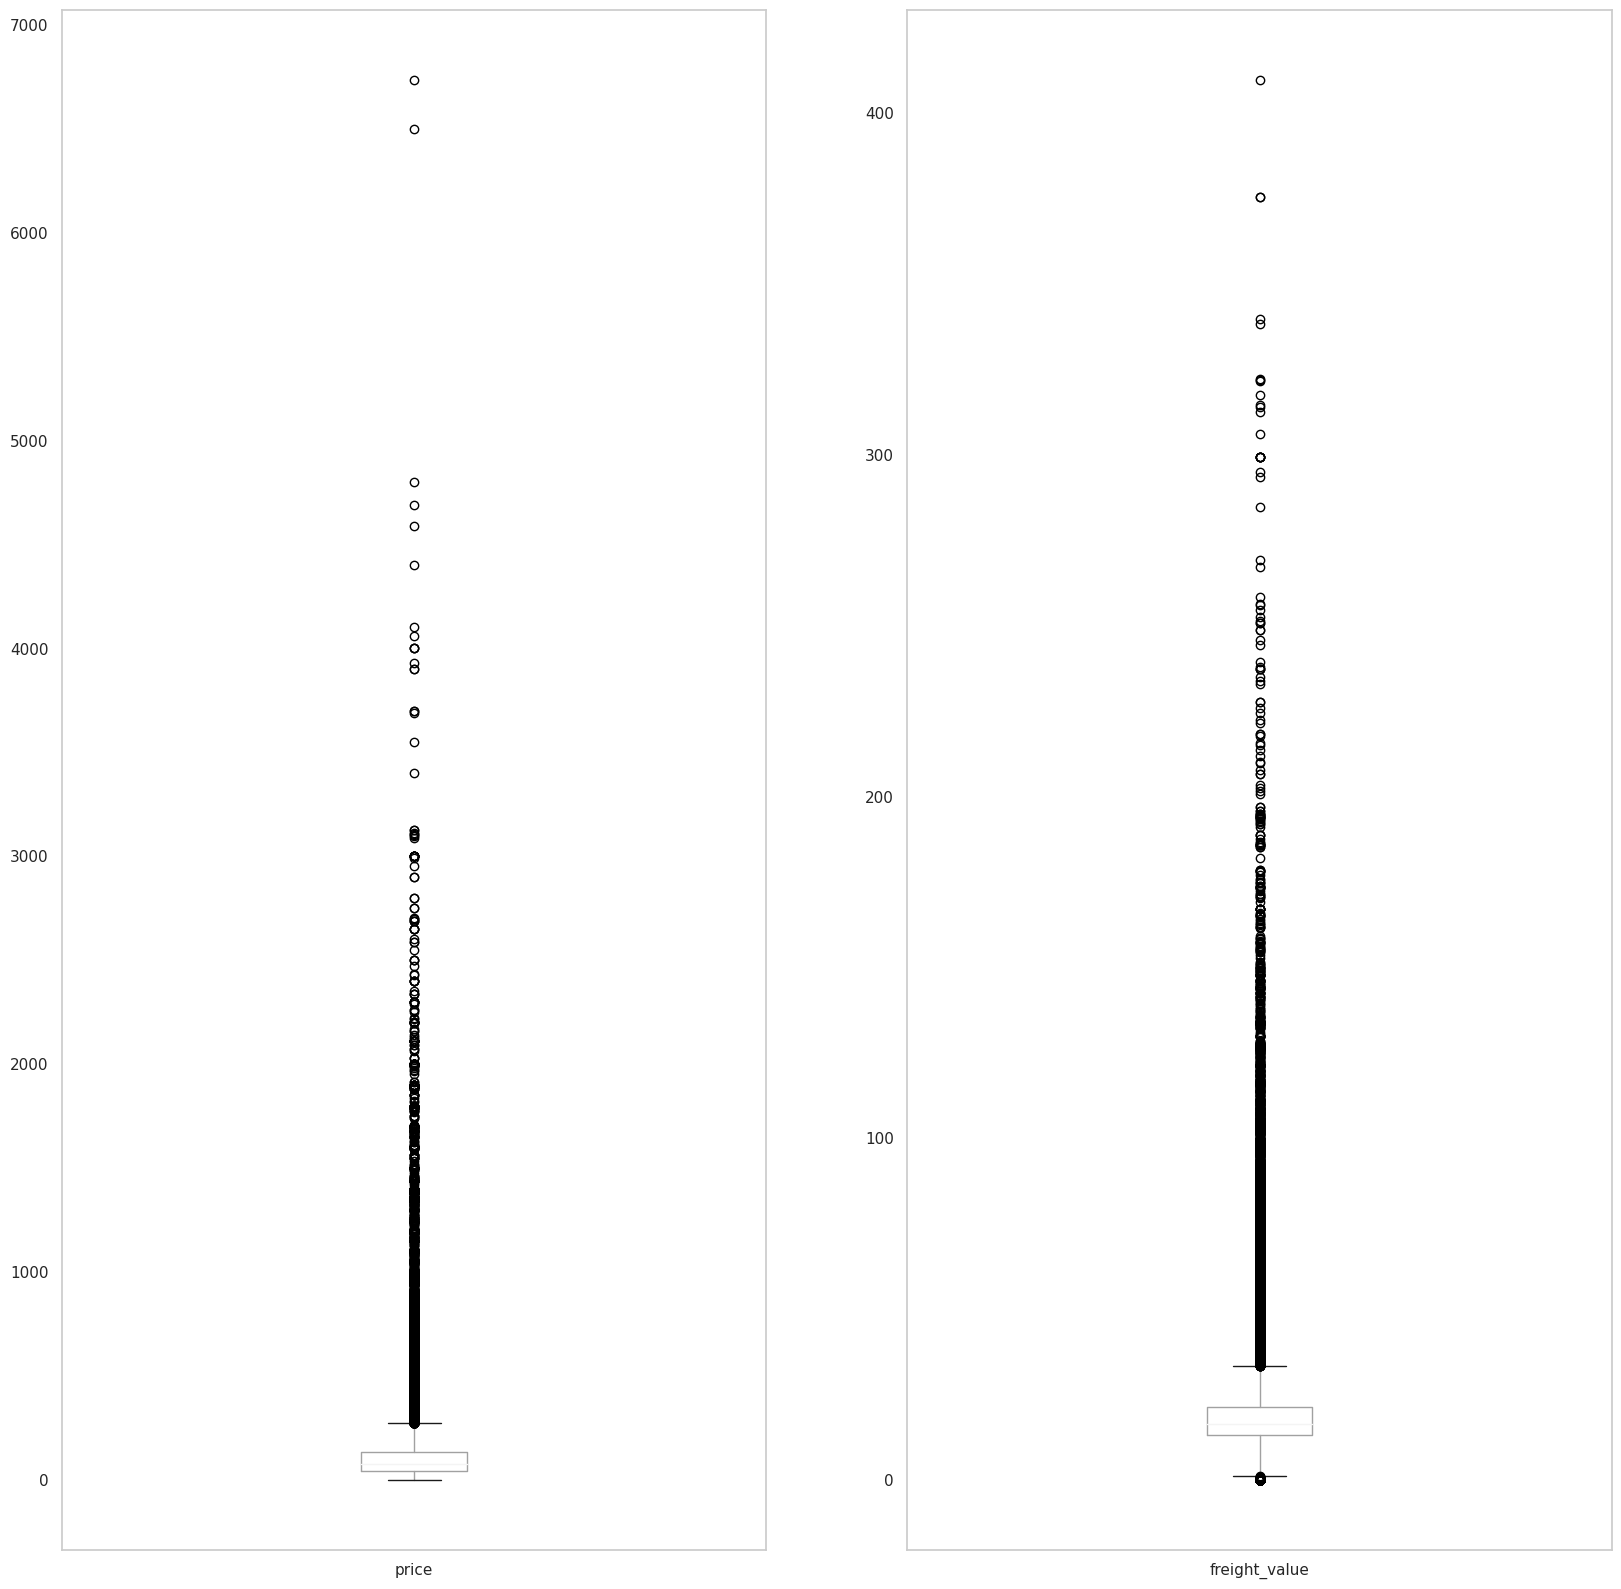

In [ ]:
numerical_column = ['price', 'freight_value']

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,20))
for i,el in enumerate(numerical_column):
    a = df_olist.boxplot(el, ax=axes.flatten()[i],grid=False)
plt.show()

In [ ]:
#For price
Q1a = df_olist['price'].quantile(0.25)
Q3a = df_olist['price'].quantile(0.75)

IQRa = Q3a-Q1a
boxplot_mina = Q1a - 1.5 *IQRa
boxplot_maxa = Q3a + 1.5 *IQRa

mina = df_olist['price']<boxplot_mina
maxa = df_olist['price']>boxplot_maxa

df_olist = df_olist[~(mina|maxa)]

#For freight_value
Q1b = df_olist['freight_value'].quantile(0.25)
Q3b = df_olist['freight_value'].quantile(0.75)

IQRb = Q3b-Q1b
boxplot_minb = Q1b - 1.5 *IQRa
boxplot_maxb = Q3b + 1.5 *IQRa

minb = df_olist['freight_value']<boxplot_minb
maxb = df_olist['freight_value']>boxplot_maxb

df_olist = df_olist[~(minb|maxb)]

df_olist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104662 entries, 0 to 115608
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       104662 non-null  object        
 1   order_item_id                  104662 non-null  int64         
 2   product_id                     104662 non-null  object        
 3   seller_id                      104662 non-null  object        
 4   shipping_limit_date            104662 non-null  datetime64[ns]
 5   price                          104662 non-null  float64       
 6   freight_value                  104662 non-null  float64       
 7   customer_id                    104662 non-null  object        
 8   order_status                   104662 non-null  object        
 9   order_purchase_timestamp       104662 non-null  datetime64[ns]
 10  order_approved_at              104662 non-null  datetime64[ns]
 11  

# Exploratory Data Analysis

Before we explore more on the dataset, we found that there is no column that indicates how many quantities that ordered by customer.

The order item table does not have a separate column for order quantity. Instead, it uses repeated order lines with a running count called `order_item_id`. To perform order profile analysis, we need a quantity column. So, we will add a new column called `order_quantity` that accumulates the order quantity.

In [ ]:
# Checking duplicate entries and duplicate order lines:
print('Total # of duplicate records: {} \n\
Total # of duplicate order lines: {}'
    .format(df_olist.duplicated().sum(),
    df_olist[['order_id', 'product_id']].duplicated().sum()))

Total # of duplicate records: 0 
Total # of duplicate order lines: 14384


Assuming `product_id` is sold by the same seller and also applied to `freight_value`,

In [ ]:
# Grouping by product_id and order_id:
df_olist = df_olist\
    .groupby(by = ['product_id','order_id'], as_index=False)\
    .agg({
        'order_item_id': 'count',
        'seller_id': 'first',
        'shipping_limit_date': 'first',
        'price': 'mean',
        'freight_value': 'first',
        'customer_id': 'first',
        'order_status': 'first',
        'order_purchase_timestamp': 'first',
        'order_approved_at': 'first',
        'order_delivered_carrier_date': 'first',
        'order_delivered_customer_date': 'first',
        'order_estimated_delivery_date': 'first',
        'product_name_lenght': 'first',
        'product_description_lenght': 'first',
        'product_photos_qty': 'first',
        'product_weight_g': 'first',
        'product_length_cm': 'first',
        'product_height_cm': 'first',
        'product_width_cm': 'first',
        'product_category_name_english': 'first',
        'customer_unique_id': 'first',
        'customer_zip_code_prefix': 'first',
        'customer_city': 'first',
        'customer_state': 'first',
        'review_id': 'first',
        'review_score': 'first',
        'review_creation_date': 'first',
        'review_answer_timestamp': 'first',
        'seller_zip_code_prefix': 'first',
        'seller_city': 'first',
        'seller_state': 'first',
        'payment_sequential': 'first',
        'payment_type': 'first',
        'payment_installments': 'first',
        'payment_value':'mean'
        })

df_olist\
    .rename(columns = {'order_item_id': 'order_quantity'}, inplace = True)

In [ ]:
df_olist['product_volume']\
    = df_olist['product_length_cm']\
    *df_olist['product_height_cm']\
    *df_olist['product_width_cm']\
    /1000

In [ ]:
# Generate total price of each transaction
df_olist['total_price'] = df_olist['order_quantity'] * df_olist['price']

In [ ]:
df_olist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90278 entries, 0 to 90277
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   product_id                     90278 non-null  object        
 1   order_id                       90278 non-null  object        
 2   order_quantity                 90278 non-null  int64         
 3   seller_id                      90278 non-null  object        
 4   shipping_limit_date            90278 non-null  datetime64[ns]
 5   price                          90278 non-null  float64       
 6   freight_value                  90278 non-null  float64       
 7   customer_id                    90278 non-null  object        
 8   order_status                   90278 non-null  object        
 9   order_purchase_timestamp       90278 non-null  datetime64[ns]
 10  order_approved_at              90278 non-null  datetime64[ns]
 11  order_delivered

In [ ]:
df_olist.head(5)

,product_id,order_id,order_quantity,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_creation_date,review_answer_timestamp,seller_zip_code_prefix,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value,product_volume,total_price
0,00066f42aeeb9f3007548bb9d3f33c38,f30149f4a8882a08895b6a242aa0d612,1,5670f4db5b62c43d542e1b2d56b0cf7c,2018-05-24,101.65,18.59,86c180c33f454b35e1596a99da3dddc4,delivered,2018-05-20,2018-05-20,2018-05-21,2018-06-06,2018-06-20,53.0,596.0,6.0,300.0,20.0,16.0,16.0,perfumery,cd929c5ecff5fc60e9d808d33702e434,95890,teutonia,RS,91845d1f2ee1fdb677c769fad86f2109,5,2018-06-07,2018-06-08,3694,sao paulo,SP,1,credit_card,3,120.24,5.120,101.65
1,00088930e925c41fd95ebfe695fd2655,f5eda0ded77c1293b04c953138c8331d,1,7142540dd4c91e2237acb7e911c4eba2,2017-12-18,129.90,13.93,68f2b37558e27791155db34bcded5ac0,delivered,2017-12-12,2017-12-12,2017-12-20,2017-12-23,2018-01-05,56.0,752.0,4.0,1225.0,55.0,10.0,26.0,automotive,cbbeff6b693e69511cf9d059f4b71036,14403,franca,SP,e5636189f943b2589b37f715a3bcae96,4,2017-12-24,2017-12-27,16301,penapolis,SP,1,credit_card,1,143.83,14.300,129.90
2,0009406fd7479715e4bef61dd91f2462,0bf736fd0fd5169d60de3699fcbcf986,1,4a3ca9315b744ce9f8e9374361493884,2017-12-29,229.00,13.10,6cd217b674e22cf568f6a2cf6060fd07,delivered,2017-12-21,2017-12-22,2018-01-02,2018-01-06,2018-01-16,50.0,266.0,2.0,300.0,45.0,15.0,35.0,bed_bath_table,f51fb63558e88eb3373773d106fa6880,2883,sao paulo,SP,32247878e34bd6e8d7dbf7b31a4ae0b0,1,2018-01-07,2018-01-11,14940,ibitinga,SP,1,credit_card,10,242.10,23.625,229.00
3,000b8f95fcb9e0096488278317764d19,3aba44d8e554ab4bb8c09f6f78032ca8,1,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-16,58.90,19.60,82b838f513e00463174cc7cae7e76c1f,delivered,2018-08-10,2018-08-10,2018-08-13,2018-08-17,2018-08-27,25.0,364.0,3.0,550.0,19.0,24.0,12.0,housewares,4e32da06df703a2561f63e75b13f6260,95174,farroupilha,RS,40f2e7bbfda859ba75411743546849b0,5,2018-08-18,2018-08-22,85603,francisco beltrao,PR,1,credit_card,4,78.50,5.472,58.90
4,000b8f95fcb9e0096488278317764d19,6f0dfb5b5398b271cc6bbd9ee263530e,1,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-07,58.90,19.60,8517e7c86998bf39a540087da6f115d9,delivered,2018-08-01,2018-08-01,2018-08-02,2018-08-07,2018-08-24,25.0,364.0,3.0,550.0,19.0,24.0,12.0,housewares,7f2dfd48dba158dbf61ba2ea631d93df,93530,novo hamburgo,RS,14303ce09673466b69c4354628aa5a84,5,2018-08-08,2018-08-08,85603,francisco beltrao,PR,1,credit_card,1,78.50,5.472,58.90


## Descriptive Analytics

In [ ]:
df_olist.describe(datetime_is_numeric = True).T

,count,mean,min,25%,50%,75%,max,std
order_quantity,90278.0,1.15933,1.0,1.0,1.0,1.0,42.0,0.657575
shipping_limit_date,90278,2018-01-09 03:15:51.540795904,2016-10-08 00:00:00,2017-09-21 00:00:00,2018-01-29 00:00:00,2018-05-11 00:00:00,2020-04-09 00:00:00,NaN
price,90278.0,85.278964,0.85,39.9,69.9,119.85,272.25,58.576358
freight_value,90278.0,18.559899,0.0,12.84,16.07,19.9275,155.82,11.447439
order_purchase_timestamp,90278,2018-01-02 12:33:59.460333824,2016-10-03 00:00:00,2017-09-15 00:00:00,2018-01-21 00:00:00,2018-05-07 00:00:00,2018-08-29 00:00:00,NaN
order_approved_at,90278,2018-01-03 00:50:07.031613696,2016-10-04 00:00:00,2017-09-15 00:00:00,2018-01-22 00:00:00,2018-05-07 00:00:00,2018-08-29 00:00:00,NaN
order_delivered_carrier_date,90278,2018-01-05 16:00:14.993686016,2016-10-08 00:00:00,2017-09-18 00:00:00,2018-01-24 00:00:00,2018-05-09 00:00:00,2018-09-11 00:00:00,NaN
order_delivered_customer_date,90278,2018-01-14 18:35:36.600279296,2016-10-11 00:00:00,2017-09-26 00:00:00,2018-02-03 00:00:00,2018-05-16 00:00:00,2018-10-17 00:00:00,NaN
order_estimated_delivery_date,90278,2018-01-26 19:08:40.552072192,2016-10-27 00:00:00,2017-10-06 00:00:00,2018-02-16 00:00:00,2018-05-29 00:00:00,2018-10-23 00:00:00,NaN
product_name_lenght,90278.0,48.893706,5.0,43.0,52.0,57.0,76.0,10.025458


In [ ]:
df_olistprod = df_olist[['order_id', 'product_id','price', 'order_status', 'order_quantity','order_purchase_timestamp','product_category_name_english', 'customer_unique_id', 'customer_state'
                         , 'order_delivered_customer_date', 'order_estimated_delivery_date','order_delivered_carrier_date','shipping_limit_date', 'seller_id','payment_value','total_price']]

df_olistprod.head(3)

,order_id,product_id,price,order_status,order_quantity,order_purchase_timestamp,product_category_name_english,customer_unique_id,customer_state,order_delivered_customer_date,order_estimated_delivery_date,order_delivered_carrier_date,shipping_limit_date,seller_id,payment_value,total_price
0,f30149f4a8882a08895b6a242aa0d612,00066f42aeeb9f3007548bb9d3f33c38,101.65,delivered,1,2018-05-20,perfumery,cd929c5ecff5fc60e9d808d33702e434,RS,2018-06-06,2018-06-20,2018-05-21,2018-05-24,5670f4db5b62c43d542e1b2d56b0cf7c,120.24,101.65
1,f5eda0ded77c1293b04c953138c8331d,00088930e925c41fd95ebfe695fd2655,129.90,delivered,1,2017-12-12,automotive,cbbeff6b693e69511cf9d059f4b71036,SP,2017-12-23,2018-01-05,2017-12-20,2017-12-18,7142540dd4c91e2237acb7e911c4eba2,143.83,129.90
2,0bf736fd0fd5169d60de3699fcbcf986,0009406fd7479715e4bef61dd91f2462,229.00,delivered,1,2017-12-21,bed_bath_table,f51fb63558e88eb3373773d106fa6880,SP,2018-01-06,2018-01-16,2018-01-02,2017-12-29,4a3ca9315b744ce9f8e9374361493884,242.10,229.00


In [ ]:
df_olistprod['purchase_date'] = pd.to_datetime(df_olistprod['order_purchase_timestamp']).dt.date
df_olistprod['purchase_year'] = pd.to_datetime(df_olistprod['order_purchase_timestamp']).dt.year
df_olistprod['purchase_month'] = pd.to_datetime(df_olistprod['order_purchase_timestamp']).dt.month
df_olistprod['purchase_MMYYYY'] = pd.to_datetime(df_olistprod['order_purchase_timestamp']).dt.strftime('%b-%y')
df_olistprod['purchase_day'] = pd.to_datetime(df_olistprod['order_purchase_timestamp']).dt.day_name()

df_olistprod.head(3)

<ipython-input-111-65660b4d4169>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-111-65660b4d4169>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-111-65660b4d4169>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-111-656

,order_id,product_id,price,order_status,order_quantity,order_purchase_timestamp,product_category_name_english,customer_unique_id,customer_state,order_delivered_customer_date,order_estimated_delivery_date,order_delivered_carrier_date,shipping_limit_date,seller_id,payment_value,total_price,purchase_date,purchase_year,purchase_month,purchase_MMYYYY,purchase_day
0,f30149f4a8882a08895b6a242aa0d612,00066f42aeeb9f3007548bb9d3f33c38,101.65,delivered,1,2018-05-20,perfumery,cd929c5ecff5fc60e9d808d33702e434,RS,2018-06-06,2018-06-20,2018-05-21,2018-05-24,5670f4db5b62c43d542e1b2d56b0cf7c,120.24,101.65,2018-05-20,2018,5,May-18,Sunday
1,f5eda0ded77c1293b04c953138c8331d,00088930e925c41fd95ebfe695fd2655,129.90,delivered,1,2017-12-12,automotive,cbbeff6b693e69511cf9d059f4b71036,SP,2017-12-23,2018-01-05,2017-12-20,2017-12-18,7142540dd4c91e2237acb7e911c4eba2,143.83,129.90,2017-12-12,2017,12,Dec-17,Tuesday
2,0bf736fd0fd5169d60de3699fcbcf986,0009406fd7479715e4bef61dd91f2462,229.00,delivered,1,2017-12-21,bed_bath_table,f51fb63558e88eb3373773d106fa6880,SP,2018-01-06,2018-01-16,2018-01-02,2017-12-29,4a3ca9315b744ce9f8e9374361493884,242.10,229.00,2017-12-21,2017,12,Dec-17,Thursday


## Trend of Revenue by Month

In [ ]:
#create df order_M to calculate no of delivered orders by month:
ord_Mt=df_olistprod.pivot_table(values = ['order_id', 'total_price']
                              , index=['purchase_year','purchase_month','purchase_MMYYYY']
                              , aggfunc={'order_id':'nunique','total_price':'sum'})

#sort data by timing (for purchase_MMYYY col):
ord_Mt = ord_Mt.sort_index(ascending=[1,1,1])
ord_Mt.reset_index(inplace = True)
del ord_Mt['purchase_year']
del ord_Mt['purchase_month']
ord_Mt.set_index('purchase_MMYYYY', inplace=True)
ord_Mt['revenue($R1000)']=ord_Mt['total_price']/1000
del ord_Mt['total_price']

# Calculate the percentage of monthly growth
ord_Mt['growth_percentage'] = ord_Mt['revenue($R1000)'].pct_change() * 100

ord_Mt

,order_id,revenue($R1000),growth_percentage
purchase_MMYYYY,,,
Oct-16,233,24.62901,NaN
Dec-16,1,0.01090,-99.955743
Jan-17,647,66.86530,613343.119266
Feb-17,1457,145.26078,117.243892
Mar-17,2259,224.96907,54.872547
Apr-17,1985,194.65818,-13.473359
May-17,3169,327.54256,68.265500
Jun-17,2815,273.83277,-16.397805
Jul-17,3568,376.34853,37.437360


<ipython-input-113-6f5da26024c5>:3: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



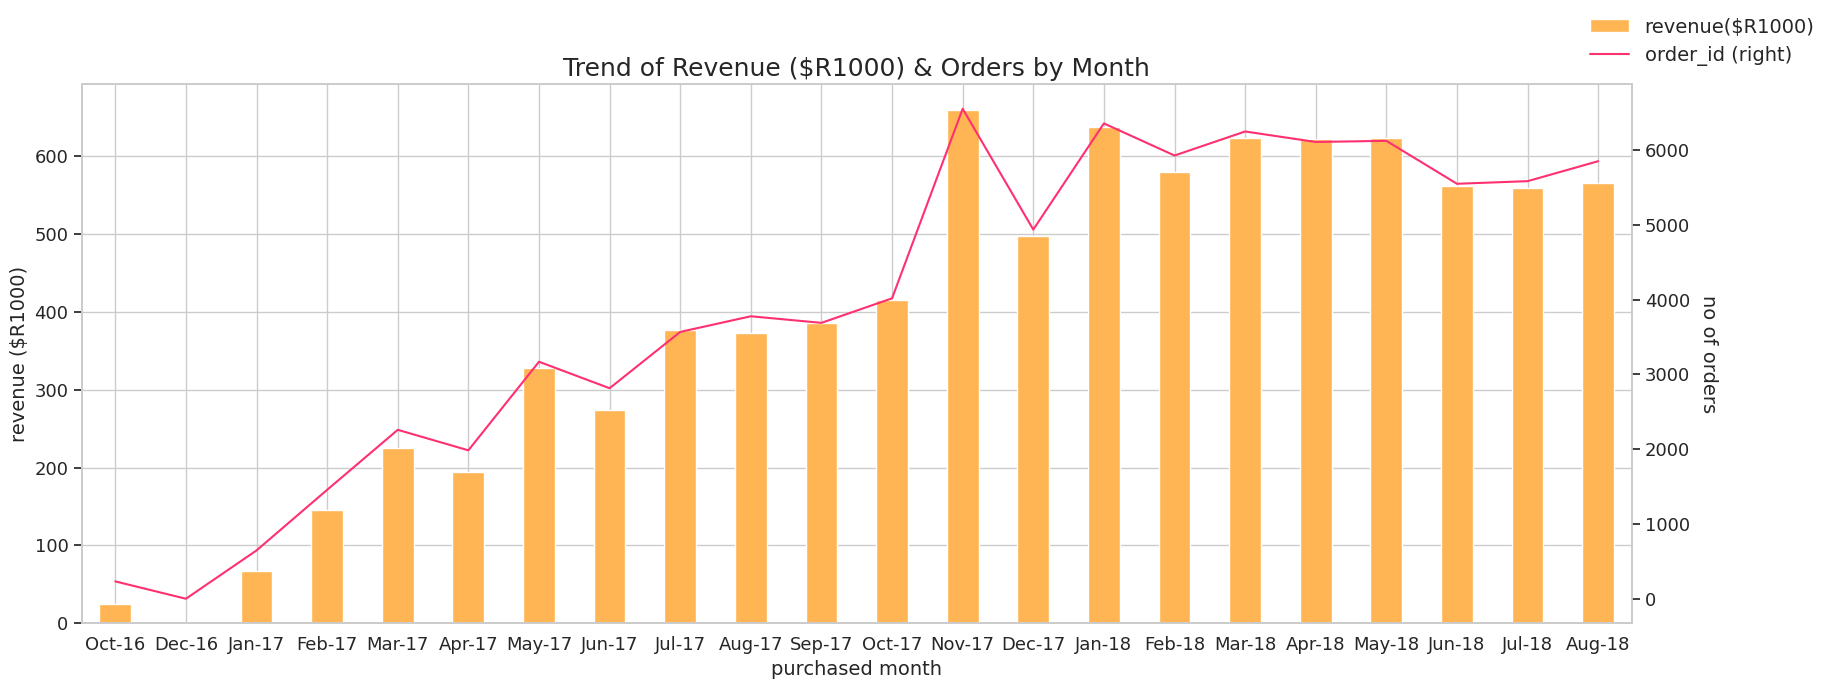

In [ ]:
#01
#set theme for all charts:
plt.style.use("seaborn-whitegrid")
sns.set_theme(style="whitegrid", palette="pastel")

#define a function to format chart:
def format_chart_trend(ax):
    ax.title.set_size(22)
    ax.xaxis.label.set_size(17)
    ax.yaxis.label.set_size(17)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)

#create df order_M to calculate no of delivered orders by month:
ord_M=df_olistprod.pivot_table(values = ['order_id', 'total_price']
                              , index=['purchase_year','purchase_month','purchase_MMYYYY']
                              , aggfunc={'order_id':'nunique','total_price':'sum'})

#sort data by timing (for purchase_MMYYY col):
ord_M = ord_M.sort_index(ascending=[1,1,1])
ord_M.reset_index(inplace = True)
del ord_M['purchase_year']
del ord_M['purchase_month']
ord_M.set_index('purchase_MMYYYY', inplace=True)
ord_M['revenue($R1000)']=ord_M['total_price']/1000
del ord_M['total_price']

#present data to line chart:
width = .45
fig = plt.figure()
ax1 = ord_M['revenue($R1000)'].plot(kind='bar', figsize=(20,7), width = width, color='#FFB554')
ax2 = ord_M['order_id'].plot(secondary_y=True, color='#FF3070')
ax1.set(ylabel='revenue ($R1000)')
ax1.set(title="Trend of Revenue ($R1000) & Orders by Month", xlabel="purchased month")
ax1.title.set_size(18)
ax1.xaxis.label.set_size(14)
ax1.yaxis.label.set_size(14)
ax1.xaxis.set_tick_params(labelsize=13)
ax1.yaxis.set_tick_params(labelsize=13)
ax2.yaxis.label.set_size(14)
ax2.yaxis.set_tick_params(labelsize=13)
ax2.set_ylabel('no of orders', rotation=-90, labelpad=20)
fig.legend(loc='upper right', fontsize=14)

#annotation of the peak point:
from datetime import datetime
peak = 'Peak of revenue & orders'
ax2.annotate(peak, xy=(12, 7300 + 100),
             xytext=(12, 7300 + 250),fontsize=15, color='red',
             arrowprops=dict(facecolor='#FC5190',shrink=0.05),
             horizontalalignment='left', verticalalignment='top')
plt.savefig('Trend of Revenue ($R1000) & Orders by Month', dpi=400, bbox_inches='tight');

### Deep dive on daily trends of Revenue in November 2017

<ipython-input-114-289ffa0d6a86>:4: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



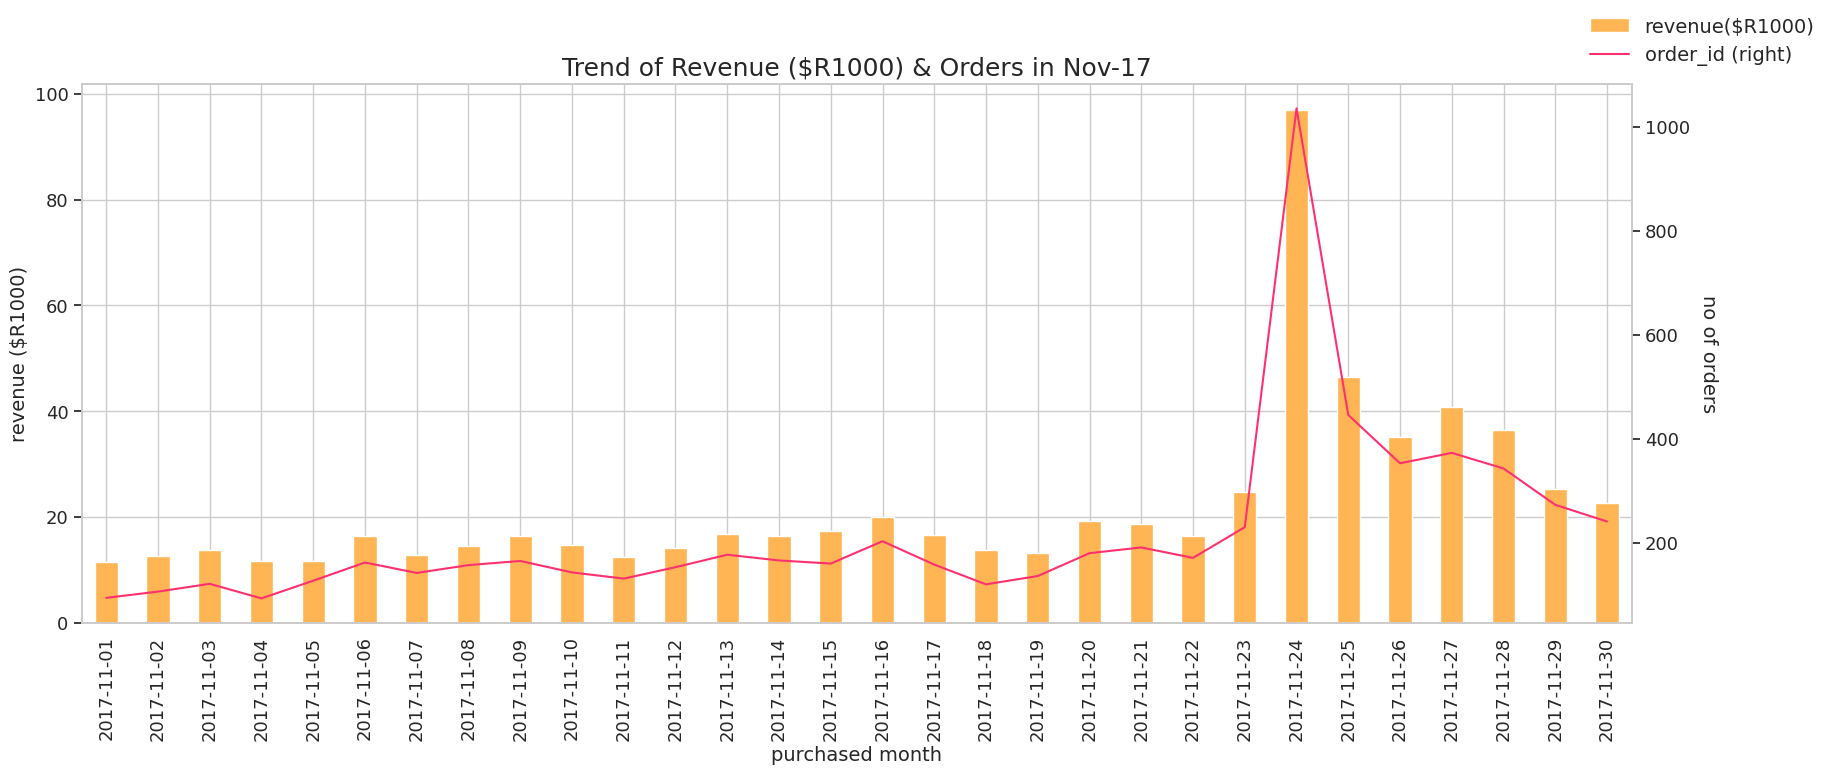

In [ ]:
### Order Trend in Nov-17 ###
#because Nov-17 has the highest revenue and orders, we dig down the data by date in Nov-17 to see the reason
#set theme for all charts:
plt.style.use("seaborn-whitegrid")
sns.set_theme(style="whitegrid", palette="pastel")

#define a function to format chart:
def format_chart_trend(ax):
    ax.title.set_size(22)
    ax.xaxis.label.set_size(17)
    ax.yaxis.label.set_size(17)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)

#create df order_M to calculate no of delivered orders by month:
ord_Nov=df_olistprod[df_olistprod['purchase_MMYYYY']== 'Nov-17'].pivot_table(values = ['order_id', 'total_price']
                              , index=['purchase_date']
                              , aggfunc={'order_id':'nunique','total_price':'sum'})

#change purchase_date to str to draw column, line chart:
ord_Nov.sort_index(ascending=True, inplace=True)
ord_Nov.reset_index(inplace = True)
ord_Nov = ord_Nov.astype({"purchase_date": str}, errors='raise')
ord_Nov.set_index('purchase_date', inplace=True)
ord_Nov['revenue($R1000)']=ord_Nov['total_price']/1000
#del ord_Nov['price']
ord_Nov
#present data to line chart:
width = .45
fig = plt.figure(figsize=(20,7))
ax1 = ord_Nov['revenue($R1000)'].plot(kind='bar',width = width, color='#FFB554')
ax2 = ord_Nov['order_id'].plot(kind='line',secondary_y=True, color='#FF3070')
ax1.set(ylabel='revenue ($R1000)')
ax1.set(title="Trend of Revenue ($R1000) & Orders in Nov-17", xlabel="purchased month")
ax1.title.set_size(18)
ax1.xaxis.label.set_size(14)
ax1.yaxis.label.set_size(14)
ax1.xaxis.set_tick_params(labelsize=13, rotation=90)
ax1.yaxis.set_tick_params(labelsize=13)

ax2.yaxis.label.set_size(14)
ax2.yaxis.set_tick_params(labelsize=13)
ax2.set_ylabel('no of orders', rotation=-90, labelpad=20)
fig.legend(loc='upper right', fontsize=14)

#annotation of the peak point:
peak = 'Peak of revenue & orders'
ax2.annotate(peak, xy=(23, 1147),
             xytext=(23+0.5, 1147 + 50),fontsize=15, color='red',
             arrowprops=dict(facecolor='#FC5190',shrink=0.05),
             horizontalalignment='left', verticalalignment='top')
plt.savefig('Trend of Revenue ($R1000) & Orders in Nov-17', dpi=400, bbox_inches='tight');

Based on above chart, it shown that the highest total # of orders happen in 24 November 2017 which apparently there was "Black Friday" celebration.

Reference: [Discount Sales on Black Friday](https://www.independent.co.uk/news/world/black-friday-2017-brazil-shoppers-discount-sales-brazil-south-africa-a8073651.html)

## Trend of AOV by Month

In [ ]:
# Group by month and year, calculate total revenue and number of orders
monthly_stats = df_olistprod.groupby(['purchase_year', 'purchase_month']).agg({
    'total_price': 'sum',
    'order_quantity': 'sum'
})

# Calculate the Average Order Value (AOV)
monthly_stats['AOV'] = monthly_stats['total_price'] / monthly_stats['order_quantity']

# Reset the index and rename the columns if desired
monthly_stats = monthly_stats.reset_index().rename(columns={
    'purchase_year': 'Year',
    'purchase_month': 'Month',
    'total_price': 'Total Revenue',
    'order_quantity': 'Total Orders'
})

# Sort the data by year and month if needed
monthly_stats = monthly_stats.sort_values(['Year', 'Month'])

# Print the monthly AOV statistics
monthly_stats

,Year,Month,Total Revenue,Total Orders,AOV
0,2016,10,24629.01,301,81.823953
1,2016,12,10.90,1,10.900000
2,2017,1,66865.30,864,77.390394
3,2017,2,145260.78,1756,82.722540
4,2017,3,224969.07,2771,81.186961
5,2017,4,194658.18,2354,82.692515
6,2017,5,327542.56,3865,84.745811
7,2017,6,273832.77,3354,81.643640
8,2017,7,376348.53,4408,85.378523
9,2017,8,372631.42,4604,80.936451


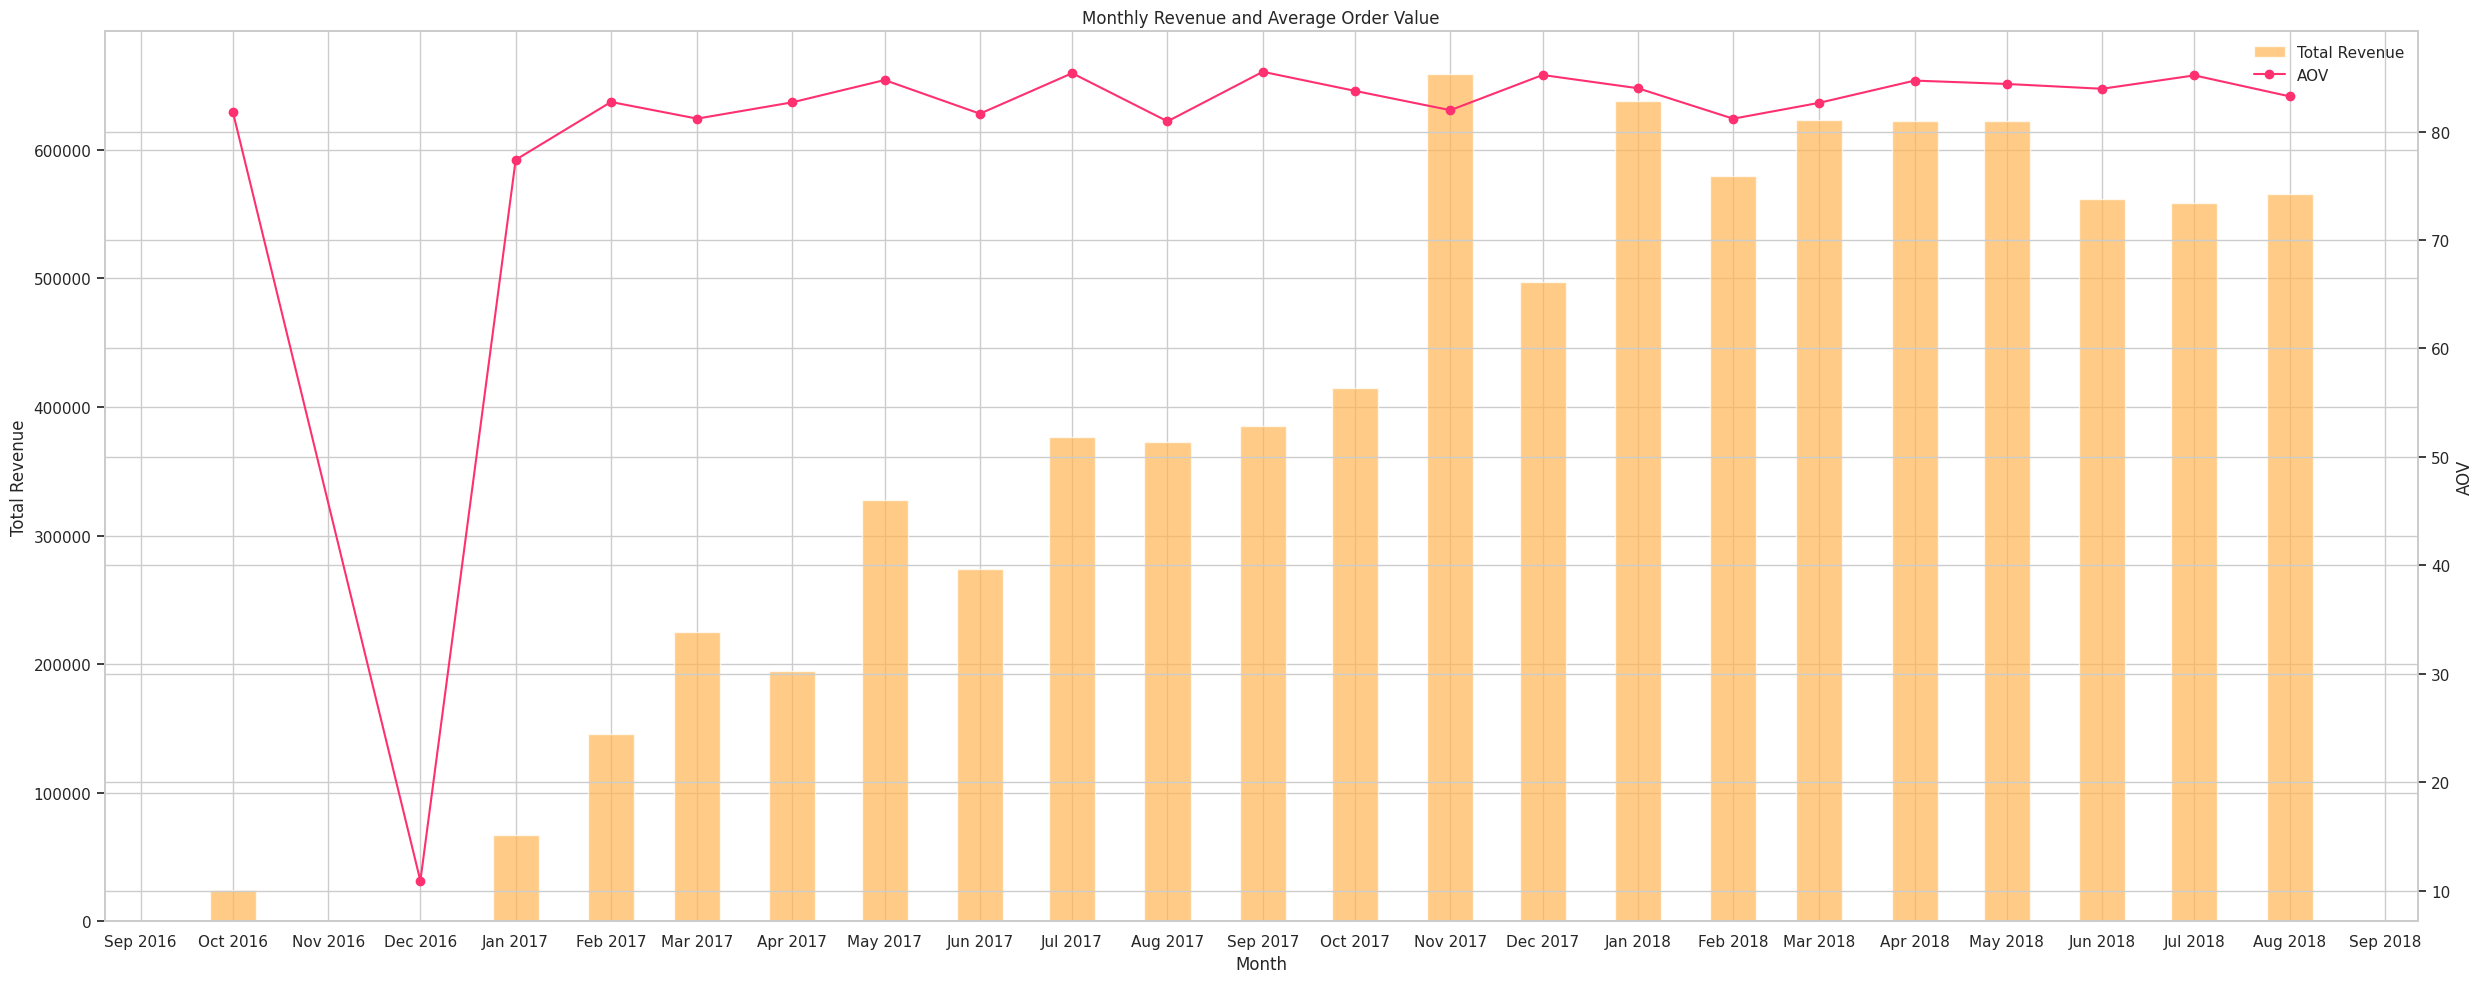

In [ ]:
# Convert 'Year' and 'Month' columns to datetime format
monthly_stats['Period'] = pd.to_datetime(monthly_stats[['Year', 'Month']].assign(day=1))

# Plotting the data
fig, ax1 = plt.subplots(figsize=(25, 10))

# Bar plot for total revenue and total orders
ax1.bar(monthly_stats['Period'], monthly_stats['Total Revenue'], width = 15, color='#FFB554', alpha=0.7, label='Total Revenue')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Revenue')
ax1.tick_params(axis='y')

# Twin axes for AOV line plot
ax2 = ax1.twinx()
ax2.plot(monthly_stats['Period'], monthly_stats['AOV'], color='#FF3070', marker='o', label='AOV')
ax2.set_ylabel('AOV')
ax2.tick_params(axis='y')

# Formatting x-axis with month and year labels
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Adding a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Adding a title
plt.title('Monthly Revenue and Average Order Value')

# Display the plot
plt.tight_layout()
plt.show()

Now, we acknowledge the first contribute of significant increase on November 2017 and sharp decline on December 2017 is because possible marketing campaign of **Black Friday** that drive **high volume** of total order in November 2017.

From that point, we will explore more on the impact of the increase in total orders.

## Customer Satisfactory

### Counting 1 and 2 star Rating

As beginning, we will try to analysis on customer satifactory through **rating**

The rating system used to evaluate an shopping experience or product quality is as follows::

1 star = very bad

2 stars = bad

3 stars = average

4 stars = good

5 stars = very good

*the more stars the better the experience/product

Most of the time, this type of rating system is used in e-commerce.
Pranata et al. (2013) found that this system was the “most preferred rating system” for both users who are asked to rate and for users who are viewing ratings.

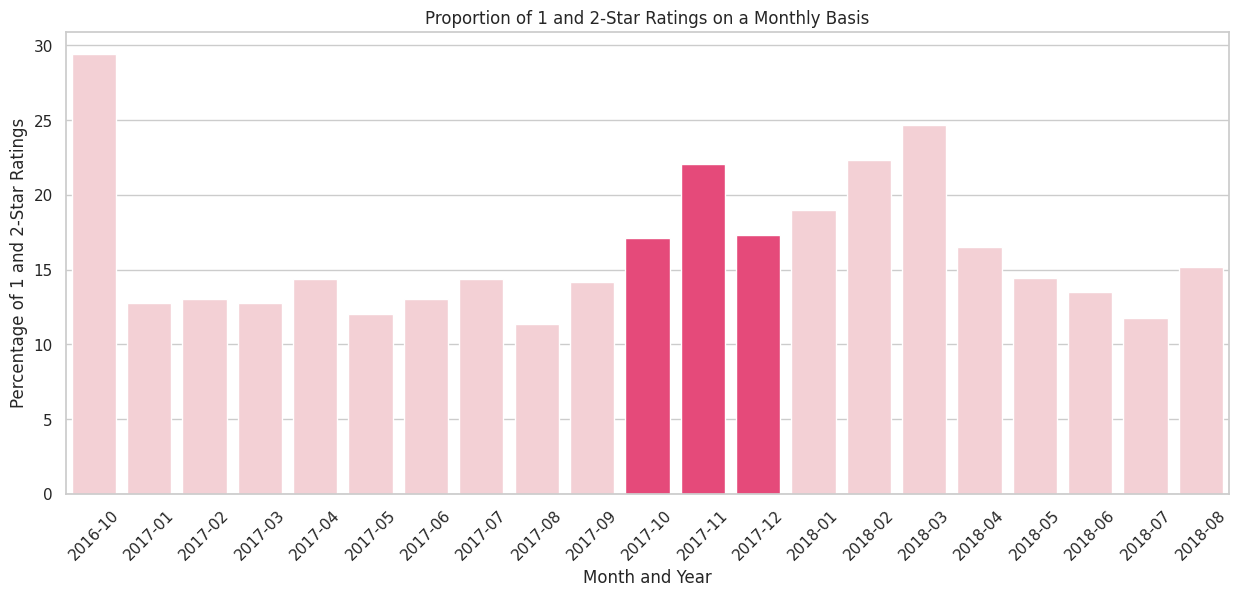

In [ ]:
neg_rv = df_olist.copy()[(df_olist['review_score'] == 1) | (df_olist['review_score'] == 2)][['review_id', 'order_id', 'review_score', 'review_creation_date', 'review_answer_timestamp']]
neg_rv = pd.merge(neg_rv, df_olist[['order_id', 'order_purchase_timestamp']], on='order_id', how='left')
neg_rv['ord_monthyear'] = neg_rv['order_purchase_timestamp'].dt.to_period('M')
neg_rv_month = neg_rv.groupby('ord_monthyear').count()['review_id'].reset_index().rename(columns={'review_id': 'total_neg_rv'})

all_rv_month = df_olist.groupby(df_olist['order_purchase_timestamp'].dt.to_period('M')).size().reset_index(name='total_all_rv')

review_counts = pd.merge(neg_rv_month, all_rv_month, left_on='ord_monthyear', right_on='order_purchase_timestamp', how='inner')
review_counts['percentage_neg_rv'] = (review_counts['total_neg_rv'] / review_counts['total_all_rv']) * 100

custom_palette = [
    '#f9cad1', '#f9cad1', '#f9cad1',
    '#f9cad1', '#f9cad1', '#f9cad1',
    '#f9cad1', '#f9cad1', '#f9cad1','#f9cad1',
    '#ff3070', '#ff3070', '#ff3070'
]

plt.figure(figsize=(15, 6))
sns.barplot(data=review_counts, x='ord_monthyear', y='percentage_neg_rv', palette=custom_palette)
plt.xticks(rotation=45)
plt.xlabel('Month and Year')
plt.ylabel('Percentage of 1 and 2-Star Ratings')
plt.title('Proportion of 1 and 2-Star Ratings on a Monthly Basis')
plt.show()


In [ ]:
review_chart = df_olist[['review_id', 'order_id', 'review_score', 'review_creation_date', 'review_answer_timestamp']].copy()

review_chart.to_csv('review_chart.csv')


In [ ]:
review_counts

,ord_monthyear,total_neg_rv,order_purchase_timestamp,total_all_rv,percentage_neg_rv
0,2016-10,73,2016-10,248,29.435484
1,2017-01,87,2017-01,680,12.794118
2,2017-02,197,2017-02,1514,13.011889
3,2017-03,299,2017-03,2337,12.794181
4,2017-04,295,2017-04,2054,14.362220
5,2017-05,397,2017-05,3295,12.048558
6,2017-06,380,2017-06,2914,13.040494
7,2017-07,534,2017-07,3723,14.343272
8,2017-08,448,2017-08,3934,11.387900
9,2017-09,543,2017-09,3831,14.173845


We can see in the last chart, the proportion of 1 and 2-star rating fairly higher than both previous and after November 2017 with total negative reviews is **1,607** of 7,447 total reviews.

After we review the total number of 1 and 2-star rating, we tried review the comment message of customer review

In [ ]:
df_rv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [ ]:
neg_cmt_rv=df_rv.copy()[['review_id','order_id','review_comment_message']].dropna()

In [ ]:
pt_stopwords = stopwords.words('portuguese')
def clean_cmt(txt):
  txt=re.sub('''\r|\n|\.|,|$|!|\d|\?''','',txt)

  txt=txt.lower()

  result=[]
  for i in txt.split():
    if i not in pt_stopwords:
        result.append(i)
  txt = ' '.join(result)
  return txt

neg_cmt_rv['new_cmt']=neg_cmt_rv['review_comment_message'].apply(clean_cmt)

In [ ]:
dic={}
def cmt_count(txt):
  for i in txt.split():
    if i not in dic:
      dic[i] = 1
    elif i in dic:
      dic[i]+= 1
neg_cmt_rv['new_cmt'].apply(cmt_count)

pd.Series(dic).sort_values(ascending=False)[:10].reset_index().rename(columns={'index':'word',0:'counts'})

,word,counts
0,produto,17954
1,prazo,8108
2,entrega,6286
3,antes,5592
4,chegou,5420
5,recebi,5176
6,bom,4475
7,recomendo,4006
8,entregue,3702
9,veio,3233


Here are the top three of most reviewed topic:

1.   produto (product) - 17,954 comments
2.   prazo (time) - 8,108 comments
3.   entrega (delivery) - 6,286 comments

For the simplicity, we assume that the time is about the delivery time and we need to further analysis later on.

## Product Analysis

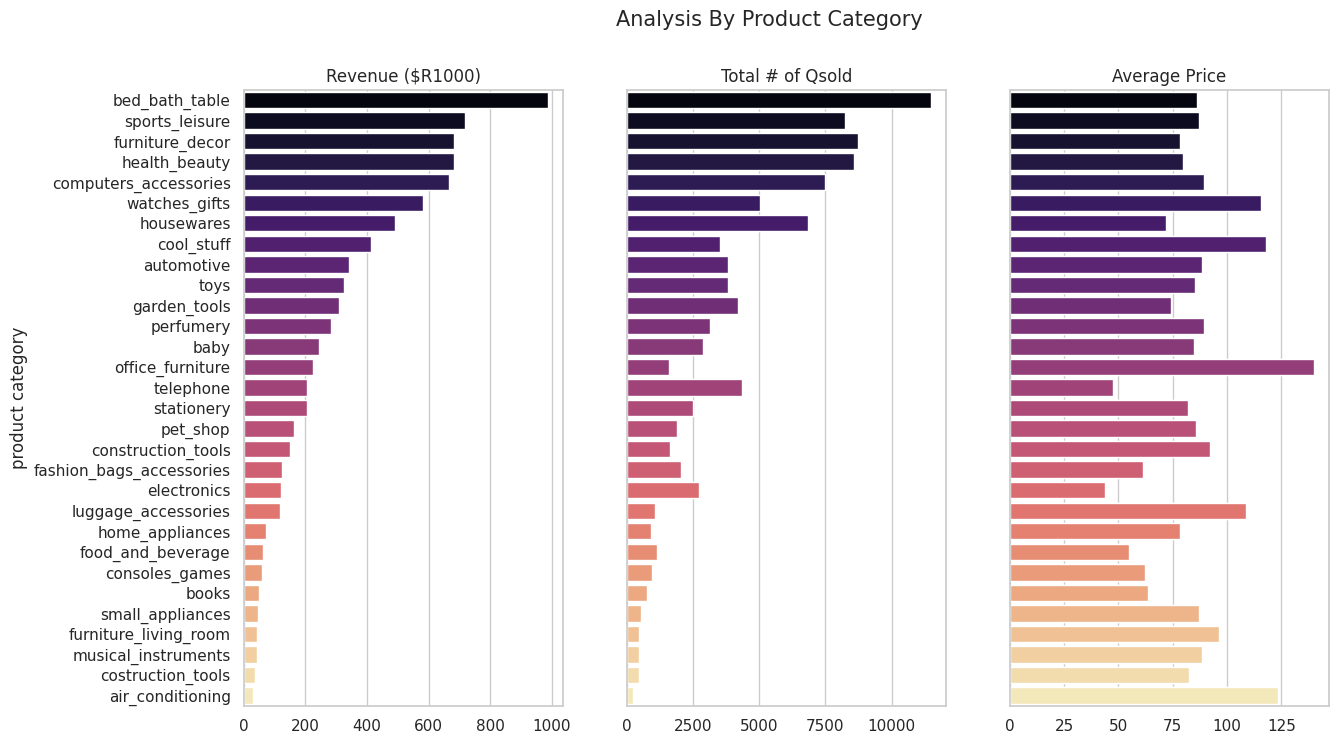

In [ ]:
###Top 30 product categories ###

#calculate revenue, no of orders, order size by top product categories:
prod_cat=df_olistprod.pivot_table(values=['total_price', 'order_quantity'], index=['product_category_name_english']
                          , aggfunc={'total_price': 'sum', 'order_quantity': 'sum'})
prod_cat["ord_size($R)"]=prod_cat["total_price"]/prod_cat["order_quantity"]
prod_cat["total_price"]=prod_cat["total_price"]/1000
prod_cat.sort_values(by='total_price', ascending = False, inplace = True)
prod_cat_top=prod_cat.rename(columns={'order_quantity':'no_of_order','total_price':"revenue($R1000)"}).head(30)

#present data to bar plots:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 8), sharey=True)
fig.suptitle('Analysis By Product Category', fontsize=15)

# original default palette
# sns.barplot(ax=ax[0], x='revenue($R1000)', y= prod_cat_top.index, data = prod_cat_top)
sns.barplot(ax=ax[0], x='revenue($R1000)', y= prod_cat_top.index, data = prod_cat_top, palette="magma")
ax[0].set_title('Revenue ($R1000)')
ax[0].set_ylabel('product category')


sns.barplot(ax=ax[1], x='no_of_order', y = prod_cat_top.index, data = prod_cat_top)
sns.barplot(ax=ax[1], x='no_of_order', y = prod_cat_top.index, data = prod_cat_top, palette="magma")
ax[1].set_title('Total # of Qsold')

sns.barplot(ax=ax[2], x='ord_size($R)', y = prod_cat_top.index, data = prod_cat_top)
sns.barplot(ax=ax[2], x='ord_size($R)', y = prod_cat_top.index, data = prod_cat_top, palette="magma")
ax[2].set_title('Average Price')

for i in range(0,3):
    ax[i].set(xlabel=None)

for i in range(1,3):
    ax[i].set(ylabel=None)

#call defined function "format_chart_small" to format charts:
plt.savefig('Analysis By Product Category', dpi=400, bbox_inches='tight');

Most of revenue generated by Olist come from consumer goods which has relative small order value. The result align with the previous chart of Trend of AOV that show the significant increase of revenue contrast on slight decrease in AOV on November 2017.

## Delivery Time

Before we proceed, let's add more variable of total days to take on shipping and delivery

In [ ]:
df_olist['approval_range_days'] = (df_olist['order_approved_at'] - df_olist['order_purchase_timestamp'])/np.timedelta64(1, 'D')
df_olist['shipping_preparation_days'] = (df_olist['order_delivered_carrier_date'] - df_olist['order_approved_at'])/np.timedelta64(1, 'D')
df_olist['shipping_status'] = df_olist.order_delivered_carrier_date <= df_olist.shipping_limit_date
df_olist['shipping_delay_days'] = (df_olist['shipping_limit_date'] - df_olist['order_delivered_carrier_date'])/np.timedelta64(1, 'D')
df_olist['shipping_delay_days'] = np.where(df_olist['shipping_delay_days'] >= 0, 0, np.abs(df_olist['shipping_delay_days']))
df_olist['time_to_shipping'] = (df_olist['order_delivered_carrier_date'] - df_olist['order_purchase_timestamp'])/np.timedelta64(1, 'D')
df_olist['delivery_status'] = df_olist.order_delivered_customer_date <= df_olist.order_estimated_delivery_date
df_olist['delivery_delay_days'] = (df_olist['order_estimated_delivery_date'] - df_olist['order_delivered_customer_date'])/np.timedelta64(1, 'D')
df_olist['delivery_delay_days'] = np.where(df_olist['delivery_delay_days'] >= 0, 0, np.abs(df_olist['delivery_delay_days']))
df_olist['time_to_deliver'] = (df_olist['order_delivered_customer_date'] - df_olist['order_purchase_timestamp'])/np.timedelta64(1, 'D')
df_olist['delivery_days'] = (df_olist['order_delivered_customer_date'] - df_olist['order_delivered_carrier_date'])/np.timedelta64(1, 'D')

#drop error rows
df_olist = df_olist[(df_olist[['shipping_preparation_days', 'time_to_deliver','delivery_days','time_to_shipping']] > 0).all(1)]

df_olist.head(7)

,product_id,order_id,order_quantity,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_creation_date,review_answer_timestamp,seller_zip_code_prefix,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value,product_volume,total_price,approval_range_days,shipping_preparation_days,shipping_status,shipping_delay_days,time_to_shipping,delivery_status,delivery_delay_days,time_to_deliver,delivery_days
0,00066f42aeeb9f3007548bb9d3f33c38,f30149f4a8882a08895b6a242aa0d612,1,5670f4db5b62c43d542e1b2d56b0cf7c,2018-05-24,101.65,18.59,86c180c33f454b35e1596a99da3dddc4,delivered,2018-05-20,2018-05-20,2018-05-21,2018-06-06,2018-06-20,53.0,596.0,6.0,300.0,20.0,16.0,16.0,perfumery,cd929c5ecff5fc60e9d808d33702e434,95890,teutonia,RS,91845d1f2ee1fdb677c769fad86f2109,5,2018-06-07,2018-06-08,3694,sao paulo,SP,1,credit_card,3,120.24,5.120,101.65,0.0,1.0,True,0.0,1.0,True,0.0,17.0,16.0
1,00088930e925c41fd95ebfe695fd2655,f5eda0ded77c1293b04c953138c8331d,1,7142540dd4c91e2237acb7e911c4eba2,2017-12-18,129.90,13.93,68f2b37558e27791155db34bcded5ac0,delivered,2017-12-12,2017-12-12,2017-12-20,2017-12-23,2018-01-05,56.0,752.0,4.0,1225.0,55.0,10.0,26.0,automotive,cbbeff6b693e69511cf9d059f4b71036,14403,franca,SP,e5636189f943b2589b37f715a3bcae96,4,2017-12-24,2017-12-27,16301,penapolis,SP,1,credit_card,1,143.83,14.300,129.90,0.0,8.0,False,2.0,8.0,True,0.0,11.0,3.0
2,0009406fd7479715e4bef61dd91f2462,0bf736fd0fd5169d60de3699fcbcf986,1,4a3ca9315b744ce9f8e9374361493884,2017-12-29,229.00,13.10,6cd217b674e22cf568f6a2cf6060fd07,delivered,2017-12-21,2017-12-22,2018-01-02,2018-01-06,2018-01-16,50.0,266.0,2.0,300.0,45.0,15.0,35.0,bed_bath_table,f51fb63558e88eb3373773d106fa6880,2883,sao paulo,SP,32247878e34bd6e8d7dbf7b31a4ae0b0,1,2018-01-07,2018-01-11,14940,ibitinga,SP,1,credit_card,10,242.10,23.625,229.00,1.0,11.0,False,4.0,12.0,True,0.0,16.0,4.0
3,000b8f95fcb9e0096488278317764d19,3aba44d8e554ab4bb8c09f6f78032ca8,1,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-16,58.90,19.60,82b838f513e00463174cc7cae7e76c1f,delivered,2018-08-10,2018-08-10,2018-08-13,2018-08-17,2018-08-27,25.0,364.0,3.0,550.0,19.0,24.0,12.0,housewares,4e32da06df703a2561f63e75b13f6260,95174,farroupilha,RS,40f2e7bbfda859ba75411743546849b0,5,2018-08-18,2018-08-22,85603,francisco beltrao,PR,1,credit_card,4,78.50,5.472,58.90,0.0,3.0,True,0.0,3.0,True,0.0,7.0,4.0
4,000b8f95fcb9e0096488278317764d19,6f0dfb5b5398b271cc6bbd9ee263530e,1,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-07,58.90,19.60,8517e7c86998bf39a540087da6f115d9,delivered,2018-08-01,2018-08-01,2018-08-02,2018-08-07,2018-08-24,25.0,364.0,3.0,550.0,19.0,24.0,12.0,housewares,7f2dfd48dba158dbf61ba2ea631d93df,93530,novo hamburgo,RS,14303ce09673466b69c4354628aa5a84,5,2018-08-08,2018-08-08,85603,francisco beltrao,PR,1,credit_card,1,78.50,5.472,58.90,0.0,1.0,True,0.0,1.0,True,0.0,6.0,5.0
6,0011c512eb256aa0dbbb544d8dffcf6e,bb9552306cf6879fde49f4ba3bd94299,1,b4ffb71f0cb1b1c3d63fad021ecf93e1,2017-12-22,52.00,15.80,5e6ef5df32d231c3564df878e325d301,delivered,2017-12-14,2017-12-14,2017-12-16,2017-12-23,2018-01-12,58.0,177.0,1.0,100.0,16.0,15.0,16.0,automotive,a62e9bd0a19a1c311ee28321033c1208,37704,pocos de caldas,MG,02fd31391801a6713138bed9bc8e047b,1,2017-12-24,2017-12-26,3880,sao paulo,SP,1,credit_card,5,166.40,3.840,52.00,0.0,2.0,True,0.0,2.0,True,0.0,9.0,7.0
7,00126f27c813603687e6ce486d909d01,c9a34c30282dc36d017bc912f8d8dc91,1,cd68562d3f44870c08922d380acae552,2017-09-21,249.00,13.24,f1375b843314f00de278b414ac4c958a,delivered,2017-09-17,2017-09-17,2017-09-20,2017-09-25,2017-10-04,42.0,2461.0,1.0,700.0,25.0,5.0,15.0,cool_stuff,

Additional column:
*   approval_range_days = total days taken for seller to approved the purchase
*   shipping_preparation_days = total days taken for seller to prepare the order before send to courier
*   shipping_status =
> TRUE if seller manage to ship the order before shipping limit date (**on time**);
> FALSE if seller failed to ship the order before shipping limit date (**late**)

*   shipping_delay_days = total delay days for seller to ship the order
*   delivery_status =
> TRUE if courier manage to deliver the order before estimate delivery date (**on time**);
> FALSE if courier failed to deliver the order before estimate delivery date (**late**)

*   delivery_delay_days = total delay days for courier to deliver the order
*   time_to_deliver = total days taken for customer received the order since purchase date
*   delivery_days = total days taken by courier deliver the order

### Average # Days of Order Received by Customer

<ipython-input-126-d26bb861fe95>:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Text(0.5, 1.0, 'Monthly Average of # Days of Customer Received The Order from Purchase Date')

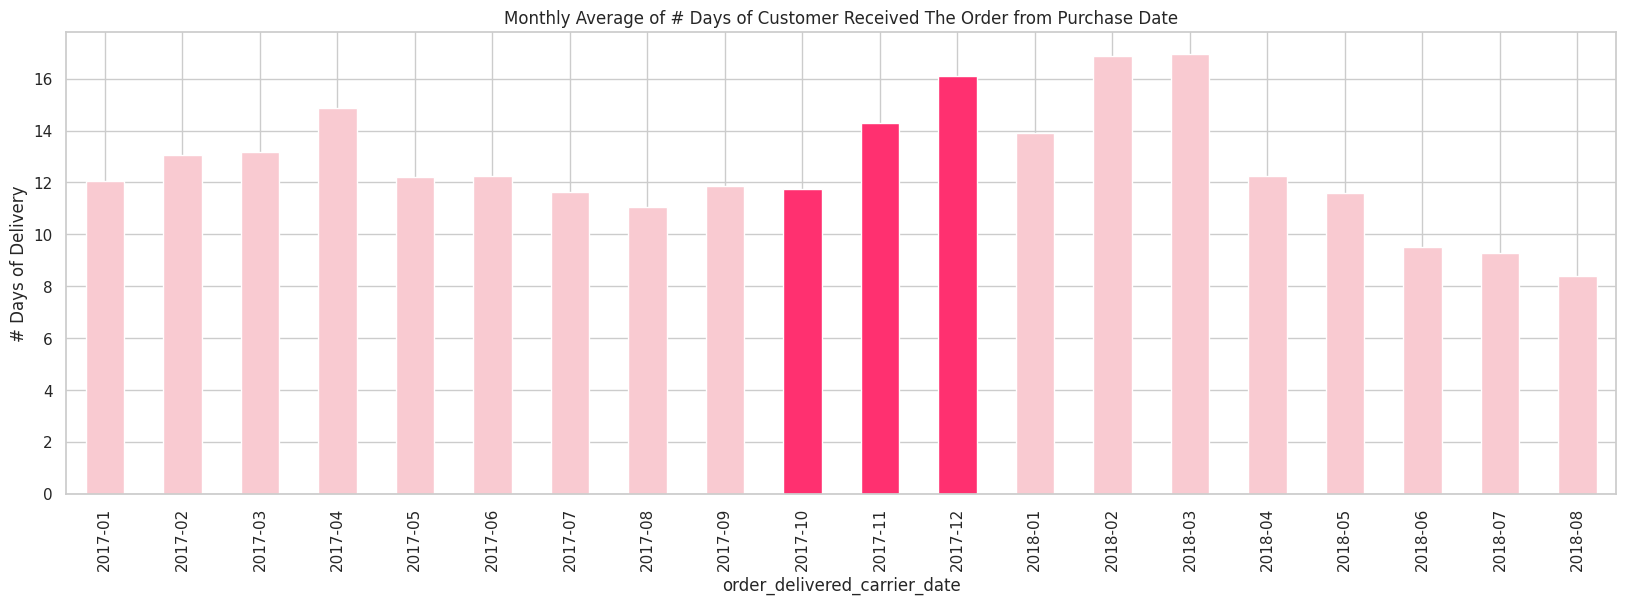

In [ ]:
time_to_deliver_m = df_olist[['order_delivered_carrier_date','time_to_deliver']]
time_to_deliver_m = time_to_deliver_m.loc[(time_to_deliver_m['order_delivered_carrier_date'] <= '2018-09-01') & (time_to_deliver_m['order_delivered_carrier_date'] >= '2017-01-01')]

colors = ('#f9cad1','#f9cad1','#f9cad1','#f9cad1','#f9cad1','#f9cad1','#f9cad1','#f9cad1','#f9cad1','#ff3070','#ff3070','#ff3070')
time_to_deliver_m.groupby([time_to_deliver_m['order_delivered_carrier_date'].dt.to_period('m')], sort=True).mean().eval('time_to_deliver')\
   .plot(kind='bar', figsize=(20,6), color=colors)

plt.xlabel("order_delivered_carrier_date")
plt.ylabel("# Days of Delivery")
plt.title("Monthly Average of # Days of Customer Received The Order from Purchase Date")

It shown that the average total days of customer received their orders increasing and from the 3-months period we analyze it reaches its peak on December 2017.

### Proportion of Rating between on-time and late delivery

In [ ]:
df_review_d = df_olist[['order_id','review_score','delivery_status','order_delivered_customer_date']]
df_review_d = df_review_d.loc[(df_review_d['order_delivered_customer_date'] >= '2017-10-01') & (df_review_d['order_delivered_customer_date'] <= '2017-12-31')]
df_review_d = df_review_d.drop(['order_delivered_customer_date'], axis=1)
df_review_d

,order_id,review_score,delivery_status
1,f5eda0ded77c1293b04c953138c8331d,4,True
6,bb9552306cf6879fde49f4ba3bd94299,1,True
8,d44be4540d1a35533a9f5c89377b77f1,5,True
9,19e2f4888f56504ec0f7e0765c9e36dc,5,True
10,7a411701d358d7be1e457ec66ceb4731,1,False
...,...,...,...
90263,4838d1c1cbef87593a3921429e633ccc,5,True
90264,6d03ab0713a35b9475f6c5ed0d989976,3,False
90265,be48bdef069ed1eb0d320bfe65d26351,5,True
90266,f179e0782e0180bc2ec9ce167d4cf245,5,True


In [ ]:
df_review_late_d = df_review_d.loc[(df_review_d['delivery_status'] == False)]

In [ ]:
df_review_late_d['review_score'].value_counts().to_frame()

,review_score
1,410
5,166
4,108
3,87
2,74


In [ ]:
df_review_ot_d = df_review_d.loc[(df_review_d['delivery_status'] == True)]

In [ ]:
df_review_ot_d['review_score'].value_counts().to_frame()

,review_score
5,7431
4,2625
3,1082
1,968
2,365


In [ ]:
import plotly.graph_objs as go

score_late_d = df_review_late_d['review_score'].value_counts().to_frame().reset_index()
score_ot_d = df_review_ot_d['review_score'].value_counts().to_frame().reset_index()

color_mapping = {
    1: '#F9CAD1',
    2: '#FFB554',
    3: '#E17EA7',
    4: '#FF6B65',
    5: '#FF3070'
}

late_colors = [color_mapping[score] for score in score_late_d['index']]
ot_colors = [color_mapping[score] for score in score_ot_d['index']]

trace1 = go.Pie(labels=score_late_d['index'], values=score_late_d['review_score'],
                domain={'x': [0, .48]}, marker=dict(colors=late_colors))
trace2 = go.Pie(labels=score_ot_d['index'], values=score_ot_d['review_score'],
                domain={'x': [0.52, 1]}, marker=dict(colors=ot_colors))
layout = dict(title="Proportion of each score. Late delivery status (left), Ontime status (right)",
              height=400, width=800)
fig = dict(data=[trace1, trace2], layout=layout)
iplot(fig)

Based on pie chart above, we can conclude that delivery delay can drive bad rating from customer

### Total Delayed Days of Top Five Product Categories

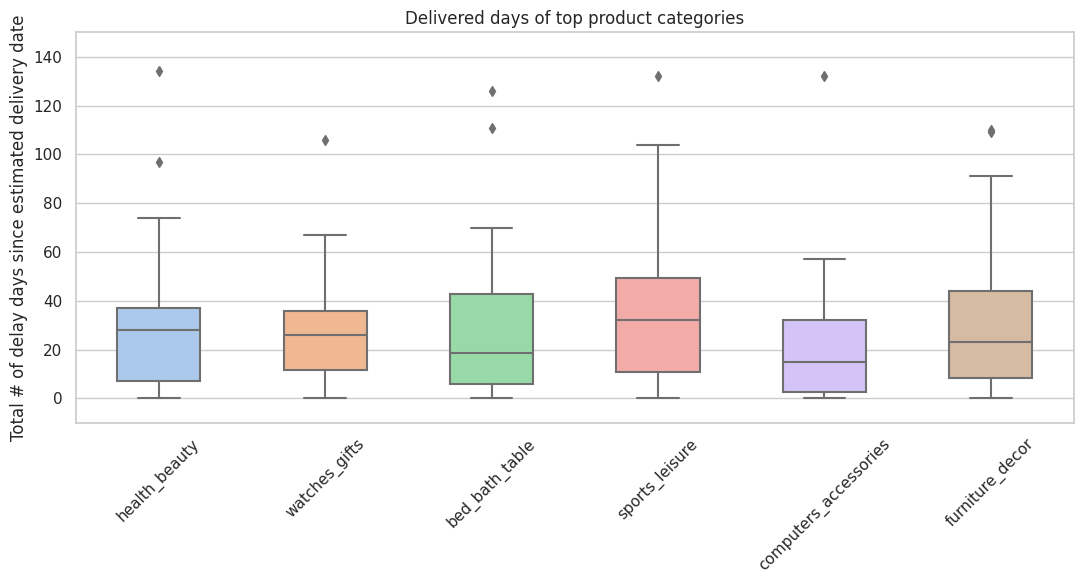

In [ ]:
###delivered days of top product categories###
#get order quantity with its delivered day & categories:
deliver_uni_ord=df_olist[['order_quantity','delivery_delay_days','product_category_name_english']].drop_duplicates(keep=False)
deli_top_pro= deliver_uni_ord[deliver_uni_ord['product_category_name_english'].isin(['bed_bath_table', 'health_beauty', 'watches_gifts','sports_leisure','computers_accessories','furniture_decor'])]

#present data to boxplot:
fig, ax = plt.subplots(figsize=(11, 6))
sns.boxplot(data=deli_top_pro, x="product_category_name_english", y="delivery_delay_days", order=['health_beauty', 'watches_gifts', 'bed_bath_table', 'sports_leisure', 'computers_accessories', 'furniture_decor'], width=0.5)  # Decrease the width parameter to 0.5 or adjust as needed
ax.set(title="Delivered days of top product categories", xlabel=None, ylabel='Total # of delay days since estimated delivery date')
ax.set_ylim(-10, 150)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Delivered days of top product categories', dpi=400, bbox_inches='tight')
plt.show()


### Delivery Days vs Rating Score

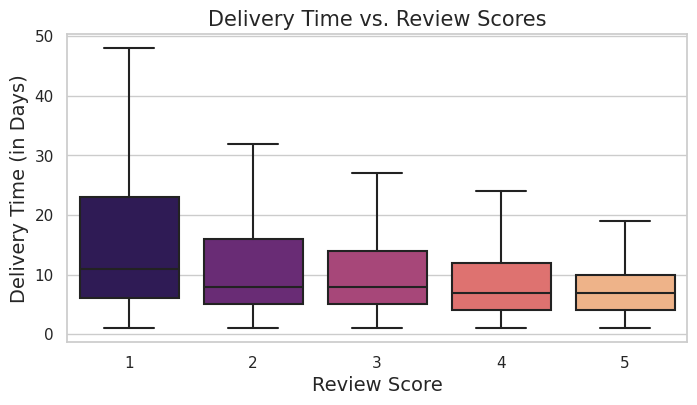

In [ ]:
plt.figure(figsize = (8, 4))
sns.boxplot(x = "review_score", y = "delivery_days", data = df_olist, showfliers = False, palette = 'magma')
plt.xlabel("Review Score", fontsize = 14)
plt.ylabel("Delivery Time (in Days)", fontsize = 14)
plt.title("Delivery Time vs. Review Scores", fontsize = 15)
plt.show()

## Top 10 Cities of Customers by Order Quantities

In [ ]:
top_orders_cities = df_olist.copy()
top_orders_cities = top_orders_cities.loc[(top_orders_cities['order_delivered_customer_date'] >= '2017-10-01') & (top_orders_cities['order_delivered_customer_date'] <= '2017-12-31')]
top_orders_cities = top_orders_cities.groupby("customer_city")["order_quantity"].count().reset_index().sort_values("order_quantity", ascending=False)
top_orders_cities

,customer_city,order_quantity
1558,sao paulo,2062
1368,rio de janeiro,969
189,belo horizonte,408
237,brasilia,297
498,curitiba,199
...,...,...
865,jose de freitas,1
868,juatuba,1
871,jucurutu,1
878,juruaia,1


Text(0.5, 1.0, 'TOP 10 cities off customer by # of orders')

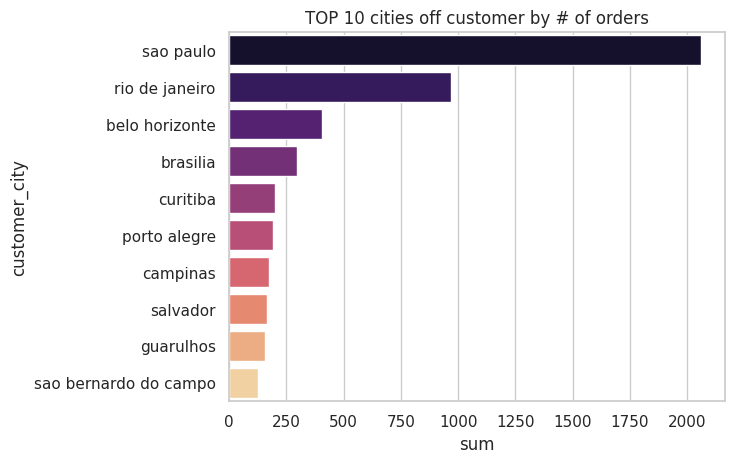

In [ ]:
top_orders_cities.rename(columns={"order_quantity":"sum"}, inplace=True)
ax = sns.barplot(x="sum", y="customer_city", data=top_orders_cities[:10], palette = 'magma')
ax.set_title("TOP 10 cities off customer by # of orders")

## Top 10 Cities of Sellers by Order Quantities

Text(0.5, 1.0, 'TOP 10 cities of sellers by # of orders')

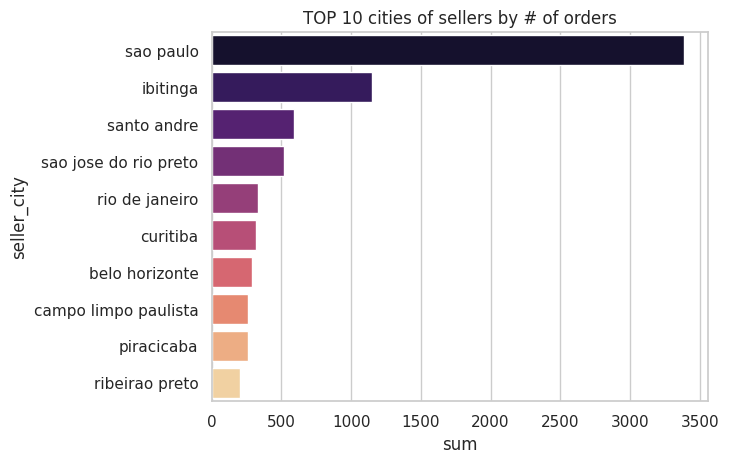

In [ ]:
top_sellers_cities = df_olist.copy()
top_sellers_cities = top_sellers_cities.loc[(top_sellers_cities['order_delivered_customer_date'] >= '2017-10-01') & (top_sellers_cities['order_delivered_customer_date'] <= '2017-12-31')]
top_sellers_cities = top_sellers_cities.groupby("seller_city")["order_quantity"].count().reset_index().sort_values("order_quantity", ascending=False)

top_sellers_cities.rename(columns={"order_quantity":"sum"}, inplace=True)
ax = sns.barplot(x="sum", y="seller_city", data=top_sellers_cities[:10], palette = 'magma')
ax.set_title("TOP 10 cities of sellers by # of orders")

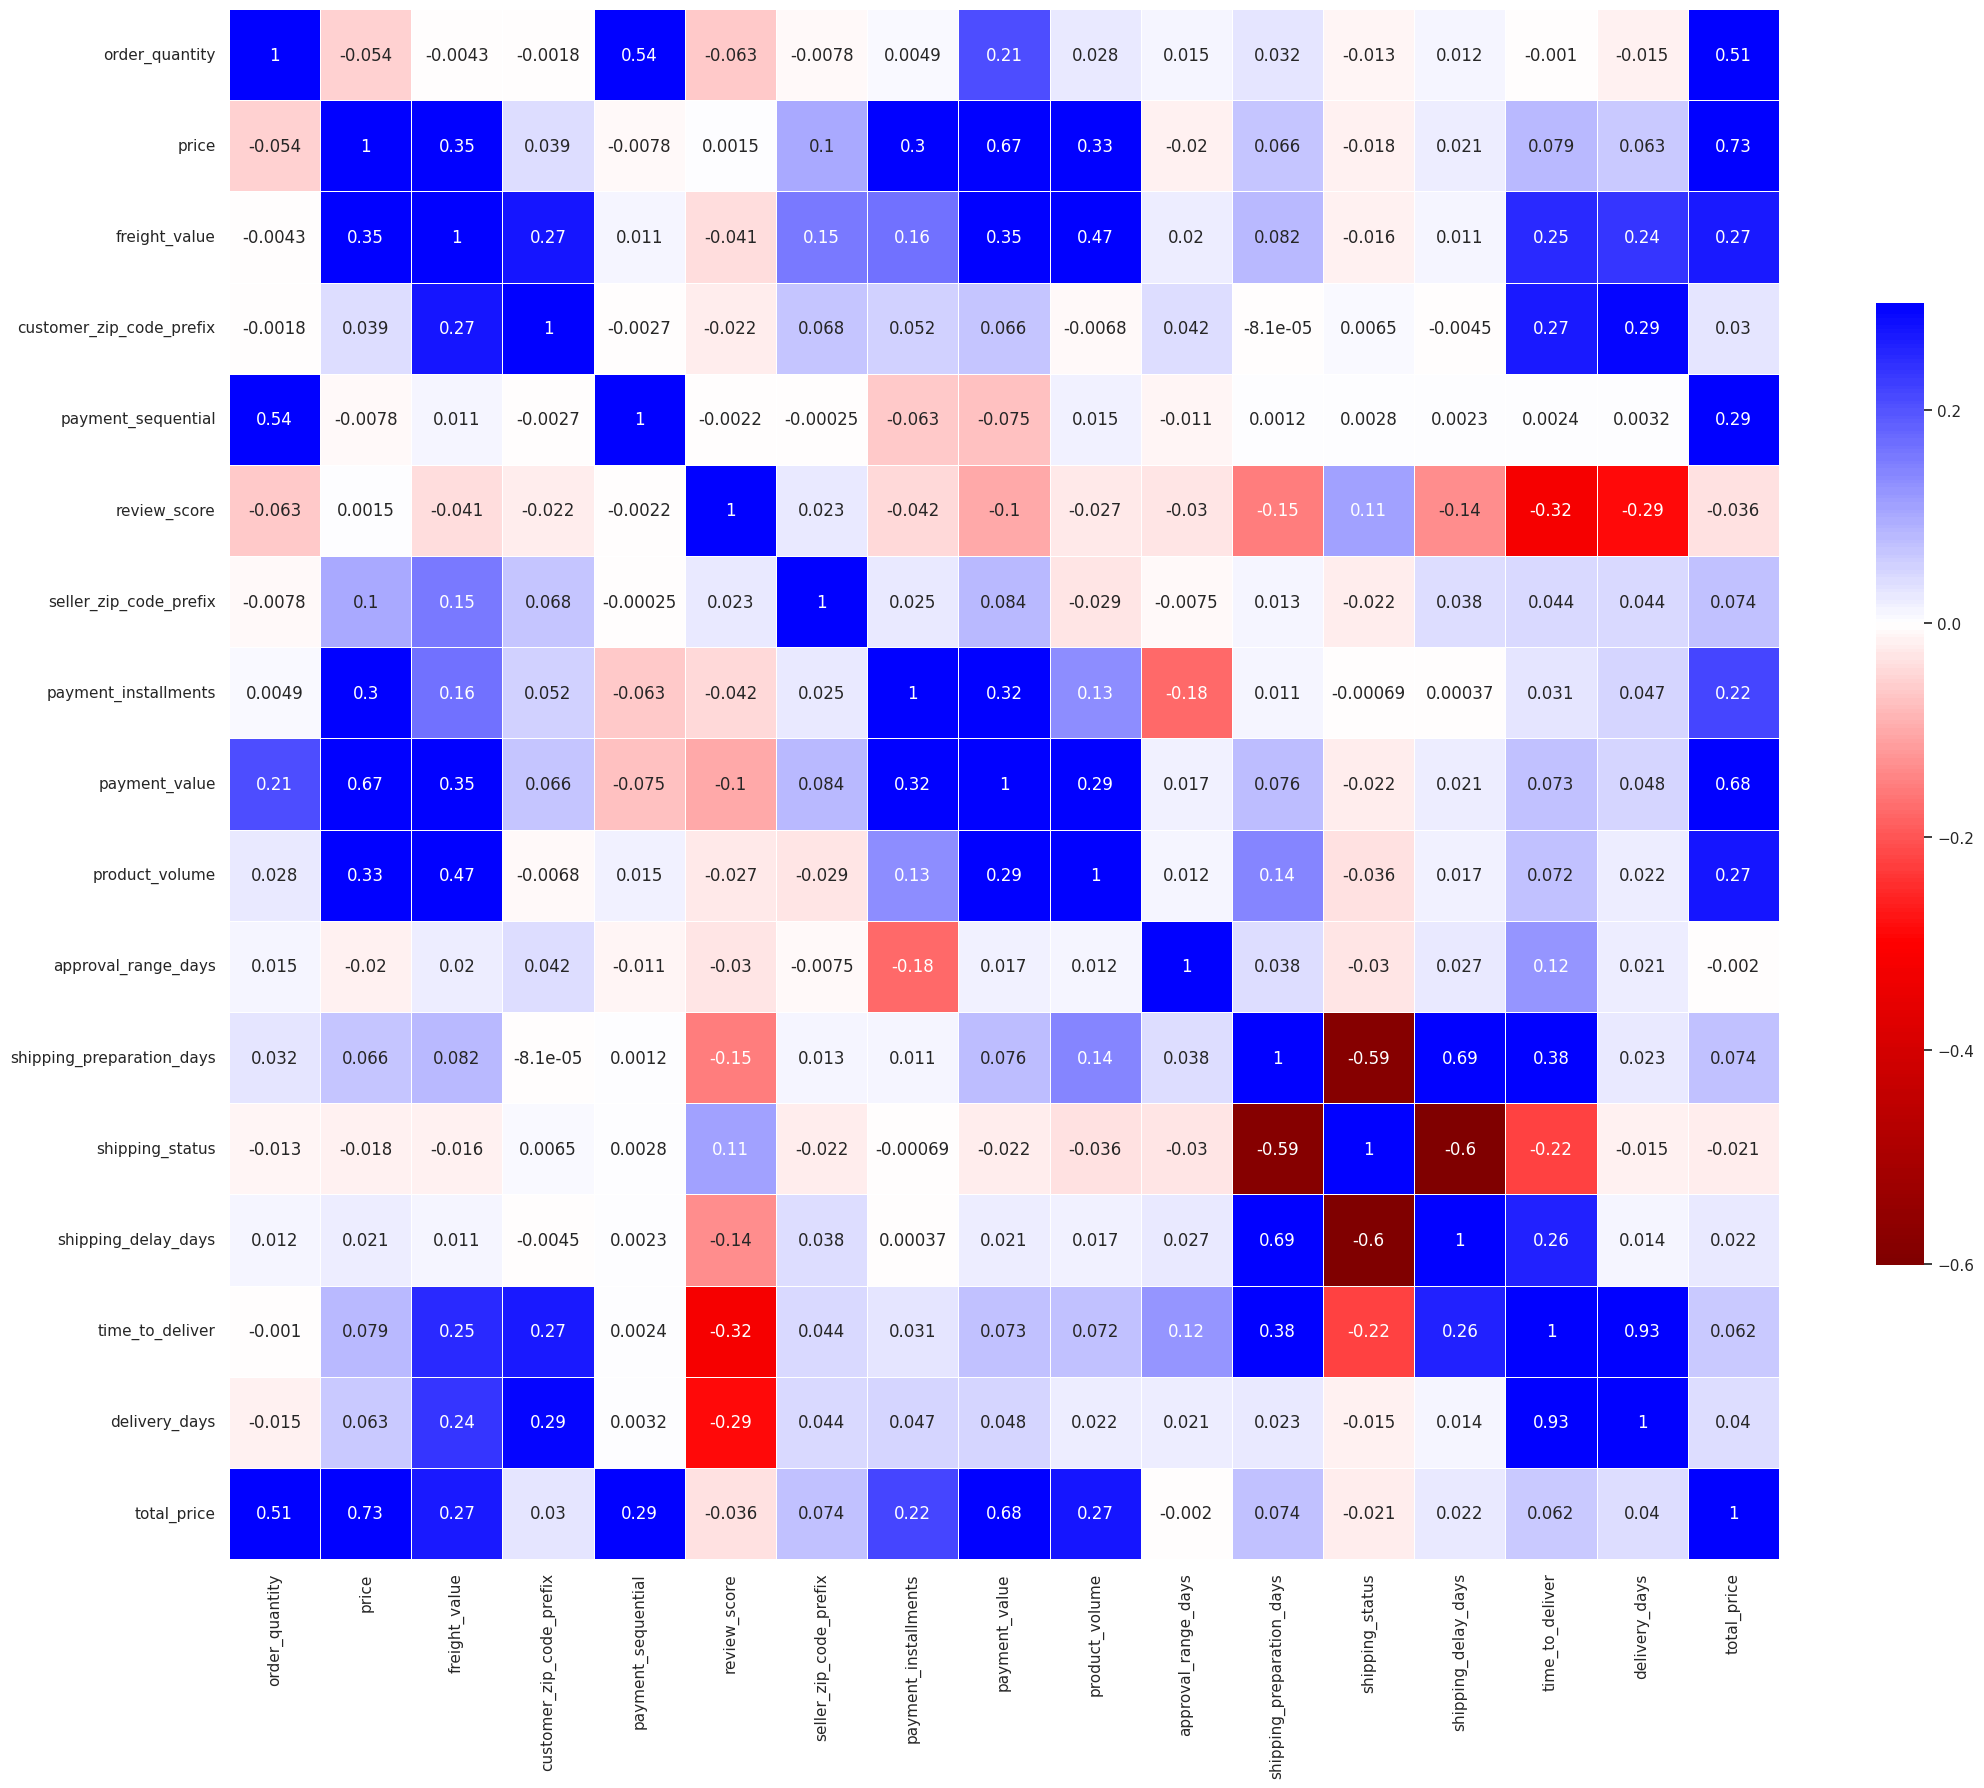

In [ ]:
plt.figure(figsize = (25, 25))
sns.heatmap(df_olist[['order_quantity','price','freight_value','customer_zip_code_prefix','payment_sequential',\
                     'review_score','seller_zip_code_prefix','payment_installments','payment_value','product_volume',\
                     'approval_range_days','shipping_preparation_days','shipping_status','shipping_delay_days',\
                    'time_to_deliver','delivery_days','total_price']].corr(),
            cmap = 'seismic_r',
            vmax = 0.3, center=0,
            square = True,
            linewidths = 0.5,
            cbar_kws = {"shrink": 0.5},
            annot = True);

In [ ]:
# Binning of product prices
df_olist['price_round']\
    = round(df_olist['total_price']/10)*10

In [ ]:
# df_ship_price_test\
#     = df_olist\
#     .groupby('price_round')\
#     .agg({
#         'shipping_duration': ['max', 'min'],
#         'estimated_duration': ['max', 'min']
#         })\
#     .reset_index()\
#     .sort_values('price_round')

# Customer Segmentation

## RFM

### **R**FM - Retention

**Recency**: How recently has the customer made a transaction with us

In [ ]:
#Grouping the data by Customer Unique ID to find the latest order of each customer:
df_recency = df_olist.groupby(by = 'customer_unique_id', as_index = False)['order_purchase_timestamp'].max()

#Renaming the column:
df_recency.rename(columns = {"order_purchase_timestamp": "LastPurchaseDate"}, inplace = True)

#Removing time and extracting only date from the datetime field:
df_recency["LastPurchaseDate"] = df_recency["LastPurchaseDate"].dt.date

#Using the last order in the entire dataset as a reference point to calculate recency:
recent_date = df_olist['order_purchase_timestamp'].dt.date.max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)

df_recency.head()

,customer_unique_id,LastPurchaseDate,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,110
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,113
2,0000f46a3911fa3c0805444483337064,2017-03-10,536
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,320
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14,287


### R**F**M - Frequency

**Frequency**: How frequent is the customer in ordering/buying some product from us

In [ ]:
#Grouping the data by Customer Unique ID to calculate the number of unique Order IDs for every customer.
df_freq = df_olist.groupby(["customer_unique_id"]).agg({"order_id": "nunique"}).reset_index()

#Renaming the column:
df_freq.rename(columns = {"order_id": "Frequency"}, inplace = True)

df_freq.head()

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


### RF**M** - Monetary

**Monetary**: How much does the customer spend on purchasing products from us.

In [ ]:
#Grouping the data by Customer Unique ID to calulcate the total spending of every customer.
df_monet = df_olist.groupby('customer_unique_id', as_index = False)['total_price'].sum()

#Renaming the column:
df_monet.rename(columns = {"total_price": "Monetary"}, inplace = True)

df_monet.head()

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00


### Merging RFM

In [ ]:
df_rfm = df_recency.merge(df_freq, on = 'customer_unique_id') \
                .merge(df_monet, on = 'customer_unique_id')

#Dropping the 'Last Purchase Date' column:
df_rfm.drop('LastPurchaseDate', axis = 1, inplace = True)

df_rfm.head(3)

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,110,1,129.9
1,0000b849f77a49e4a4ce2b2a4ca5be3f,113,1,18.9
2,0000f46a3911fa3c0805444483337064,536,1,69.0


### K-Means

In [ ]:
# Remove zeros from data before log trans
df_kmeans = df_rfm.copy()
df_kmeans[df_kmeans.columns[1:]] = df_kmeans[df_kmeans.columns[1:]].applymap(lambda x: 1 if x ==0 else x)

In [ ]:
# Running K-Means algo to cluster our data
# Let's check if data is skewed first
from scipy import stats
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    plt.show()
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

<ipython-input-146-bb8a6b6f5003>:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




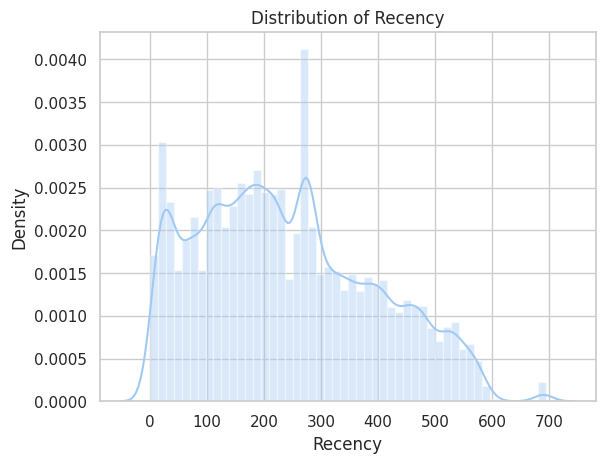

Recency's: Skew: 0.4255511506831153, : SkewtestResult(statistic=44.1404488522718, pvalue=0.0)


<ipython-input-146-bb8a6b6f5003>:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




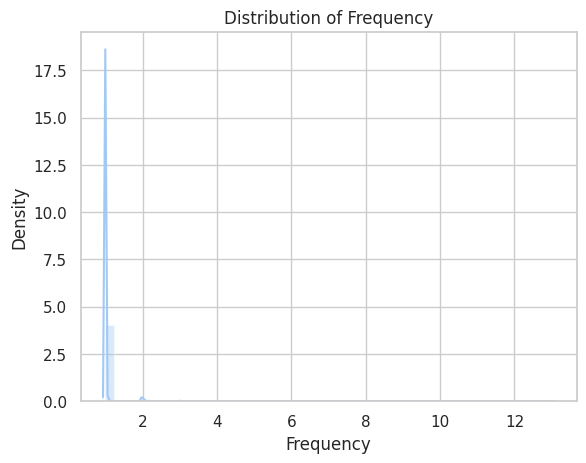

Frequency's: Skew: 11.34459828938074, : SkewtestResult(statistic=293.5939473543971, pvalue=0.0)


<ipython-input-146-bb8a6b6f5003>:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




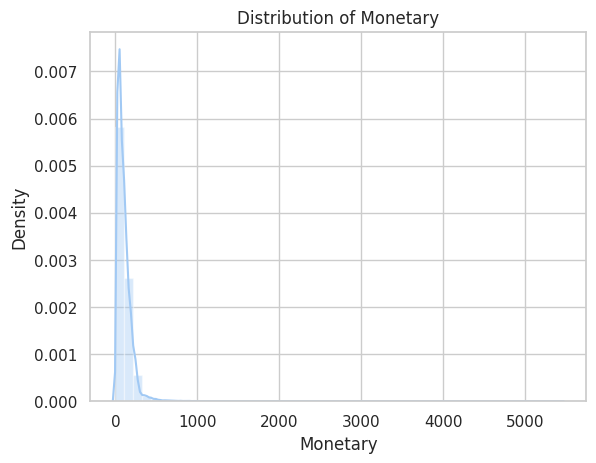

Monetary's: Skew: 7.601836788193331, : SkewtestResult(statistic=258.39077985548374, pvalue=0.0)


In [ ]:
for col in df_rfm.columns[1:]:
    check_skew(df_rfm, col)

A skewness value greater than 1 or less than -1 indicates a highly skewed distribution. A value between 0.5 and 1 or -0.5 and -1 is moderately skewed. A value between -0.5 and 0.5 indicates that the distribution is fairly symmetrical.

We'll log transform Frequency and Monetary as they are highly skwed.

In [ ]:
# Perform log transformation
df_kmeans_log = df_kmeans.copy()
for c in df_kmeans.columns[2:]:
    df_kmeans_log[c] = np.log10(df_kmeans_log[c])

<ipython-input-146-bb8a6b6f5003>:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




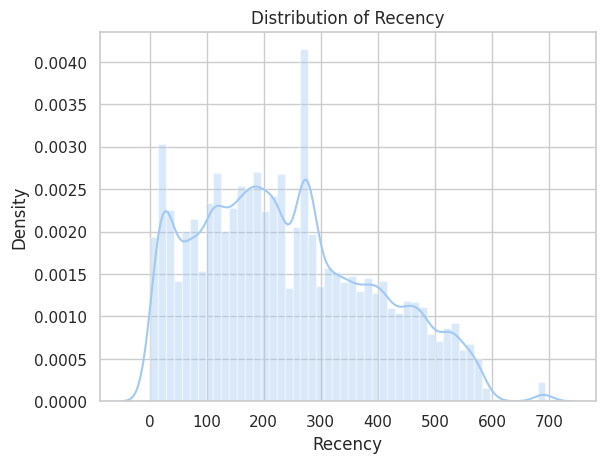

Recency's: Skew: 0.4255634510718185, : SkewtestResult(statistic=44.1416280404223, pvalue=0.0)


<ipython-input-146-bb8a6b6f5003>:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




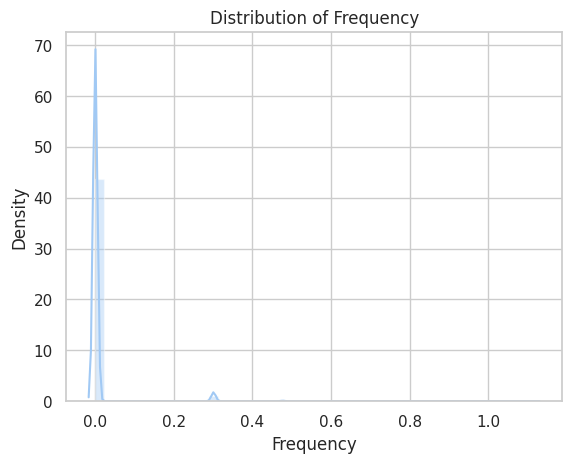

Frequency's: Skew: 6.431512403978654, : SkewtestResult(statistic=243.73238080385678, pvalue=0.0)


<ipython-input-146-bb8a6b6f5003>:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




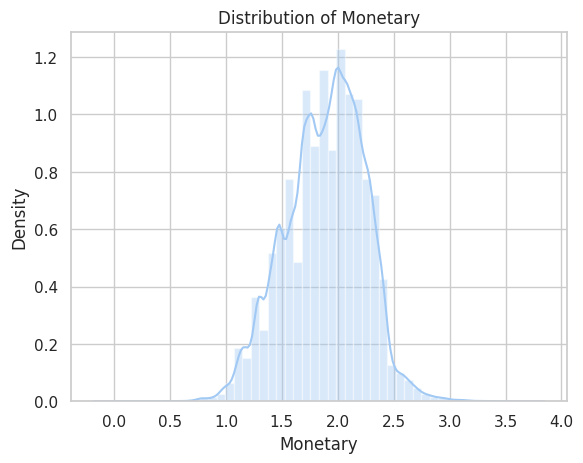

Monetary's: Skew: -0.20226964890019522, : SkewtestResult(statistic=-21.648093126588908, pvalue=6.334750112477609e-104)


In [ ]:
for col in df_kmeans.columns[1:]:
    check_skew(df_kmeans_log, col)

### Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df_kmeans_log.drop("customer_unique_id", axis=1))
RFM_Table_scaled = scaler.transform(df_kmeans_log.drop("customer_unique_id", axis=1))
# Put data into a df
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=df_kmeans_log.columns[1:])
RFM_Table_scaled.head()

,Recency,Frequency,Monetary
0,-0.859967,-0.162475,0.648526
1,-0.840170,-0.162475,-1.742845
2,1.951110,-0.162475,-0.136346
3,0.525775,-0.162475,-1.347654
4,0.308016,-0.162475,1.053197


### Elbow Method

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

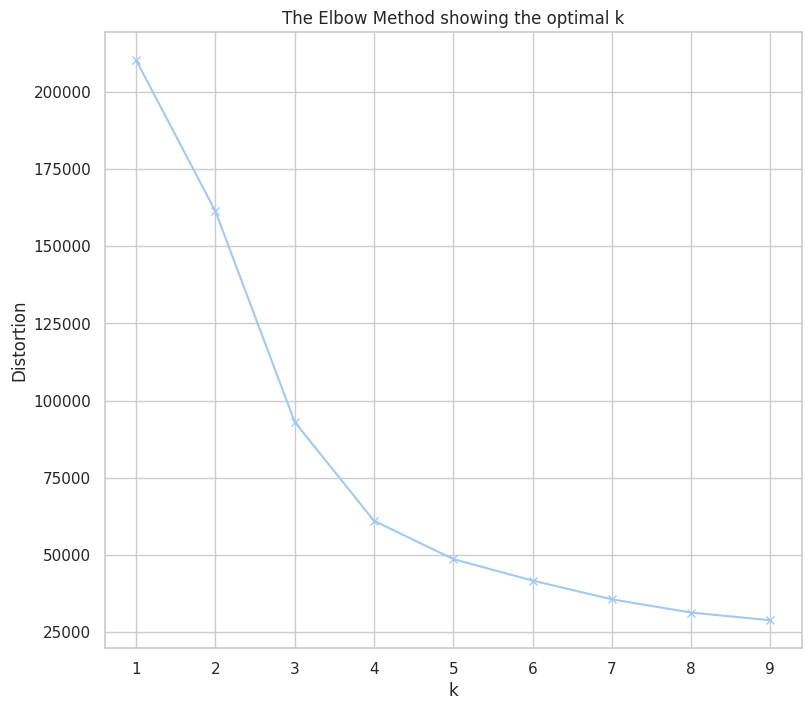

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Training k-means model

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(RFM_Table_scaled)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(9,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

## Final Model

In [ ]:
# Train the model on 4 clusters
final_model = KMeans(n_clusters=4, random_state=5)
final_model = final_model.fit(RFM_Table_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



## Segmentation Result

In [ ]:
data_output = df_rfm.copy()
data_output['Cluster'] = final_model.labels_
data_output.sample(5)

,customer_unique_id,Recency,Frequency,Monetary,Cluster
54956,c8d183727fc9b4dcac256fbe246d6270,229,1,69.90,1
849,03146a8b7c6feaac56b53e8e834eccd2,50,1,49.99,2
15840,39dc893707cd584729686523e0eb0dd3,277,1,39.90,2
10968,2811fa922f83f29c9aa74f58404bc7db,126,1,67.00,1
43836,a0746c4b9b28979012e88048753f0b74,475,1,55.90,0


In [ ]:
data_output.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70101 entries, 0 to 70100
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  70101 non-null  object 
 1   Recency             70101 non-null  int64  
 2   Frequency           70101 non-null  int64  
 3   Monetary            70101 non-null  float64
 4   Cluster             70101 non-null  int32  
dtypes: float64(1), int32(1), int64(2), object(1)
memory usage: 2.9+ MB


Merging dataset

In [ ]:
df_olist_rfm = data_output.merge(df_olist, how='right', on='customer_unique_id')
df_olist_rfm = df_olist_rfm.drop_duplicates(subset='customer_unique_id', keep='first')
df_olist_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70101 entries, 0 to 74979
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_unique_id             70101 non-null  object        
 1   Recency                        70101 non-null  int64         
 2   Frequency                      70101 non-null  int64         
 3   Monetary                       70101 non-null  float64       
 4   Cluster                        70101 non-null  int32         
 5   product_id                     70101 non-null  object        
 6   order_id                       70101 non-null  object        
 7   order_quantity                 70101 non-null  int64         
 8   seller_id                      70101 non-null  object        
 9   shipping_limit_date            70101 non-null  datetime64[ns]
 10  price                          70101 non-null  float64       
 11  freight_value  

How many customers are present in each cluster?

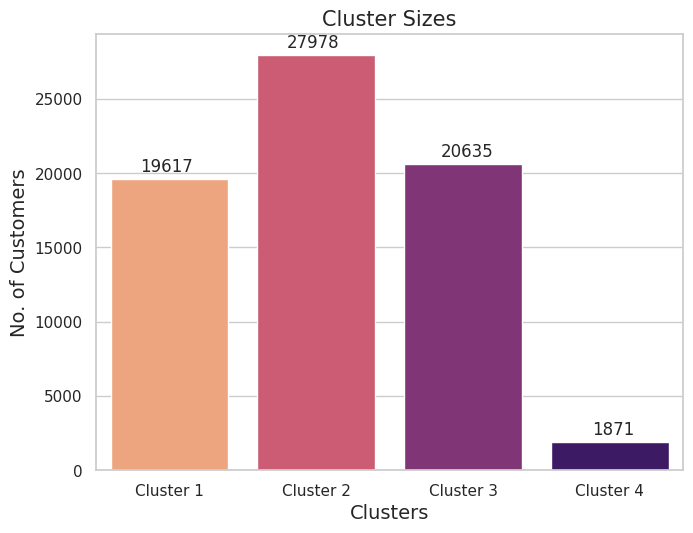

In [ ]:
sns.countplot(data = df_olist_rfm, x = 'Cluster', palette = 'magma_r')
plt.title('Cluster Sizes', fontsize = 15)
plt.xlabel('Clusters', fontsize = 14)
plt.ylabel('No. of Customers', fontsize = 14)
plt.xticks([0, 1, 2, 3], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], rotation = 0)
plt.text(x = 0 - 0.2, y = df_olist_rfm.Cluster.value_counts()[0] + 500, s = df_olist_rfm.Cluster.value_counts()[0])
plt.text(x = 1 - 0.2, y = df_olist_rfm.Cluster.value_counts()[1] + 500, s = df_olist_rfm.Cluster.value_counts()[1])
plt.text(x = 2 - 0.15, y = df_olist_rfm.Cluster.value_counts()[2] + 500, s = df_olist_rfm.Cluster.value_counts()[2])
plt.text(x = 3 - 0.12, y = df_olist_rfm.Cluster.value_counts()[3] + 500, s = df_olist_rfm.Cluster.value_counts()[3])
plt.tight_layout(pad = -1)
plt.show()

What's the average spending of customers in each cluster?

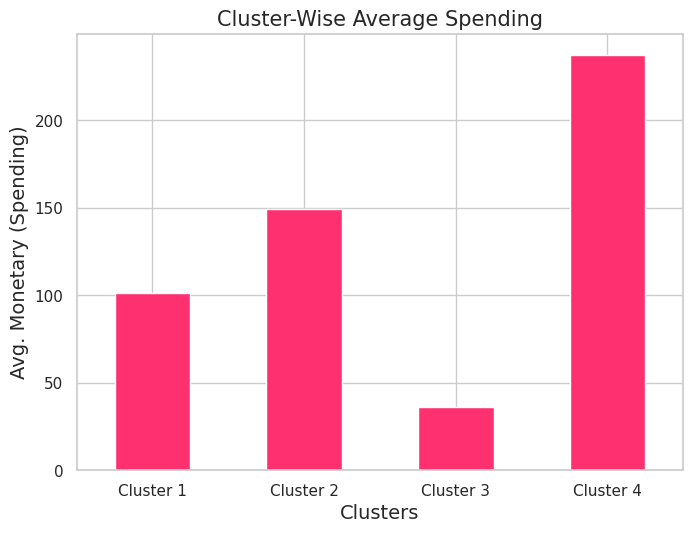

In [ ]:
monetary_averages = pd.Series(df_olist_rfm.groupby(by = 'Cluster')['Monetary'].mean())
monetary_averages.plot(kind = 'bar', color = '#FF3070')
plt.title('Cluster-Wise Average Spending', fontsize = 15)
plt.xlabel('Clusters', fontsize = 14)
plt.ylabel('Avg. Monetary (Spending)', fontsize = 14)
plt.xticks([0, 1, 2, 3], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], rotation = 0)
plt.tight_layout(pad = -1)
plt.show()

On average, how many days have passed since the customer's last order in each cluster?

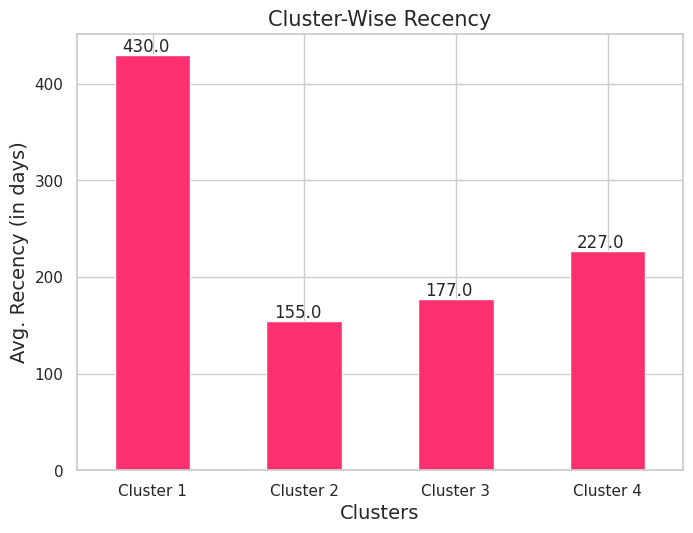

In [ ]:
recency_averages = pd.Series(df_olist_rfm.groupby(by = 'Cluster')['Recency'].mean())
recency_averages.plot(kind = 'bar', color = '#FF3070')
plt.title('Cluster-Wise Recency', fontsize = 15)
plt.xlabel('Clusters', fontsize = 14)
plt.ylabel('Avg. Recency (in days)', fontsize = 14)
plt.xticks([0, 1, 2, 3], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], rotation = 0)
plt.text(x = 0 - 0.2, y = recency_averages[0] + 3, s = "{}".format(recency_averages[0].round(0)))
plt.text(x = 1 - 0.2, y = recency_averages[1] + 3, s = "{}".format(recency_averages[1].round(0)))
plt.text(x = 2 - 0.2, y = recency_averages[2] + 3, s = "{}".format(recency_averages[2].round(0)))
plt.text(x = 3 - 0.2, y = recency_averages[3] + 3, s = "{}".format(recency_averages[3].round(0)))
plt.tight_layout(pad = -1)
plt.show()

On average, how many orders have the customers placed in each cluster?

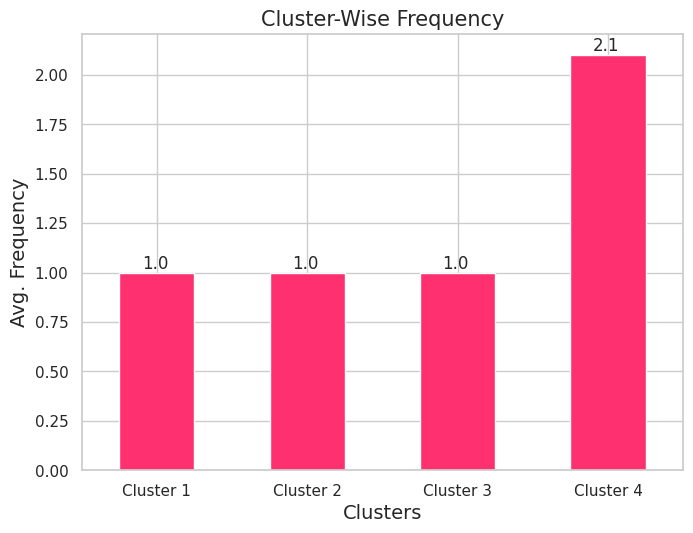

In [ ]:
frequency_averages = pd.Series(df_olist_rfm.groupby(by = 'Cluster')['Frequency'].mean())
frequency_averages.plot(kind = 'bar', color = '#FF3070')
plt.title('Cluster-Wise Frequency', fontsize = 15)
plt.xlabel('Clusters', fontsize = 14)
plt.ylabel('Avg. Frequency', fontsize = 14)
plt.xticks([0, 1, 2, 3], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], rotation = 0)
plt.text(x = 0 - 0.1, y = frequency_averages[0] + 0.02, s = frequency_averages[0].round(1))
plt.text(x = 1 - 0.1, y = frequency_averages[1] + 0.02, s = frequency_averages[1].round(1))
plt.text(x = 2 - 0.1, y = frequency_averages[2] + 0.02, s = frequency_averages[2].round(1))
plt.text(x = 3 - 0.1, y = frequency_averages[3] + 0.02, s = frequency_averages[3].round(1))
plt.tight_layout(pad = -1)
plt.show()


Aggregating the RFM data:

In [ ]:
rfm_agg = df_olist_rfm.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).round(1)

rfm_agg.rename(columns = {"Recency": "Avg. Recency",
                          "Frequency": "Avg. Frequency",
                          "Monetary": "Avg. Monetary",
                          "Cluster": "Customer Count"
                         }, inplace = True)

rfm_agg

,Avg. Recency,Avg. Frequency,Avg. Monetary,Customer Count
Cluster,,,,
0,430.1,1.0,101.2,19617
1,154.5,1.0,149.5,27978
2,177.5,1.0,36.1,20635
3,227.3,2.1,237.6,1871


**What does each cluster represent?**

* **Cluster 0** : This cluster can be considered as *Hibernating* as the recency comes the longest time and their average spending has the second lowest than other cluster.

* **Cluster 1** : This cluster can be interpreted as *Potential Loyalist* as their spending is the second highest among all clusters but have the shortest recency. This cluster is most favorable.

* **Cluster 2** : This cluster can be interpreted as *Price Sensitive* since the average spending is the lowest compare to other cluster but their recency has the second shortest day.

* **Cluster 3** : This cluster can be interpreted as *Needs Attention* since they has the highest average spending but unfortunately has the second longest time of recency.

In [ ]:
# df_olist_rfm.to_csv('df_orfm2.csv')